# **Importing library&function**






In [245]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, mean_squared_error, auc
from IPython.core.display import display, HTML
import numpy as np
import time
import os
from google.colab import drive
import itertools

!pip install split_folders
import splitfolders

!pip install scikit-learn

In [246]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [247]:
!ls /content/drive/MyDrive/ColabNotebooks/FinalProject/Dataset/grayscale/
import splitfolders
import os
loc = "/content/drive/MyDrive/ColabNotebooks/FinalProject/Dataset/grayscale/"
# csvloc = "/content/drive/MyDrive/ColabNotebooks/FinalProject/Result/"

gray_cataract  gray_diabetic_retinopathy  gray_glaucoma  gray_normal


In [248]:
import os
splitfolders.ratio(loc,output = "outputgrayscale",ratio = (0.70,0.15,0.15))
for dirpath,dirname,filename in os.walk("./outputgrayscale"):
  print(f"There are {len(dirname)} directories and {len(filename)} images in '{dirpath}'.")

Copying files: 4238 files [00:08, 513.24 files/s]


There are 3 directories and 0 images in './outputgrayscale'.
There are 4 directories and 0 images in './outputgrayscale/val'.
There are 0 directories and 261 images in './outputgrayscale/val/gray_cataract'.
There are 0 directories and 268 images in './outputgrayscale/val/gray_normal'.
There are 0 directories and 273 images in './outputgrayscale/val/gray_diabetic_retinopathy'.
There are 0 directories and 253 images in './outputgrayscale/val/gray_glaucoma'.
There are 4 directories and 0 images in './outputgrayscale/train'.
There are 0 directories and 943 images in './outputgrayscale/train/gray_cataract'.
There are 0 directories and 966 images in './outputgrayscale/train/gray_normal'.
There are 0 directories and 989 images in './outputgrayscale/train/gray_diabetic_retinopathy'.
There are 0 directories and 915 images in './outputgrayscale/train/gray_glaucoma'.
There are 4 directories and 0 images in './outputgrayscale/test'.
There are 0 directories and 158 images in './outputgrayscale/test

In [249]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 6,
                                             min_delta = 0.0001)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",factor = 0.2,
                                                patience = 4,min_lr = 1e-7)

In [250]:
data_aug = tf.keras.Sequential([
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomFlip("horizontal")
],name = "data_augmentation_layer")

In [251]:
def predict_labels(model, X_test):
    return model.predict(X_test)

def display_classification_report(y_test, y_pred):
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

def calculate_specificity(y_test, y_pred):
    # tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # specificity = tn / (tn + fp)
    # print(f"Specificity: {specificity}")
    cm = confusion_matrix(y_test, y_pred)
    specificity = []
    for i in range(cm.shape[0]):
      spec = cm[i, i] / (np.sum(cm[i, :]) - cm[i, i] + np.sum(cm[:, :]) - np.sum(cm[i, :]))
      specificity.append(spec)
    print(f"Specificity: {specificity}")

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalize
    n_classes = cm.shape[0]  # find the number of classes

    specificity = []  # To store specificity values for each class

    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    ax.set(
        title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=labels,
        yticklabels=labels
    )

    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    plt.xticks(rotation=70, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    threshold = (cm.max() + cm.min()) / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        specificity_val = (cm.sum() - cm[i].sum() - cm[:, j].sum() + cm[i, j]) / (
            cm.sum() - cm[:, j].sum()
        )
        specificity.append(specificity_val)

        if norm:
            plt.text(
                j,
                i,
                f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%,\n {specificity_val*100:.1f}%)",
                #  f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%, Specificity: {specificity_val*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size,
            )
        else:
            plt.text(
                j,
                i,
                f"{cm[i, j]} ( {specificity_val*100:.1f}%)",
                #  f"{cm[i, j]} (Specificity: {specificity_val*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size,
            )

    if savefig:
        fig.savefig("confusion_matrix.png")

    return specificity

def calculate_mse(y_test, y_probs, n_classes):
  y_true_onehot = tf.keras.utils.to_categorical(y_test, n_classes)
  mse = mean_squared_error(y_true_onehot, y_probs)
  print(f"Mean Squared Error: : {mse}")
  return y_true_onehot

def calculate_roc_auc_score(y_test, y_probs):
  auc_roc = roc_auc_score(y_test, y_probs, multi_class='ovr', average=None)
  average_auc_roc = np.mean(auc_roc)
  print(f"The average AUC-ROC is {average_auc_roc}")

In [252]:
def sharpen_image(image, factor=1.5):
    adjusted = tf.image.adjust_contrast(image, factor)
    return adjusted

# **Batch size: 16**

In [253]:
epoch = 20
batchsize = 16

In [254]:
train_dir = "outputgrayscale/train"
test_dir =  "outputgrayscale/test"
val_dir = "outputgrayscale/val"

train_classes = sorted([name for name in os.listdir(train_dir)])
class_names = train_classes  # Assuming class names are the same across train, test, and val

# Load datasets
train_data = image_dataset_from_directory(train_dir, label_mode="categorical",
                                          image_size=(224, 224), batch_size=batchsize,
                                          shuffle=True, seed=42, color_mode='grayscale')

test_data = image_dataset_from_directory(test_dir, label_mode="categorical",
                                         image_size=(224, 224), batch_size=batchsize,
                                         shuffle=False, seed=42, color_mode='grayscale')

val_data = image_dataset_from_directory(val_dir, label_mode="categorical",
                                        image_size=(224, 224), batch_size=batchsize,
                                        shuffle=False, seed=42, color_mode='grayscale')


Found 3813 files belonging to 4 classes.
Found 640 files belonging to 4 classes.
Found 1055 files belonging to 4 classes.


In [255]:
class_names = train_data.class_names  # Store class names before transformations

# Apply transformations using map() function
train_data = train_data.map(lambda x, y: (sharpen_image(x), y))
test_data = test_data.map(lambda x, y: (sharpen_image(x), y))
val_data = val_data.map(lambda x, y: (sharpen_image(x), y))


# **EfficientNetV2B3 Model**

In [256]:
efficient_model = tf.keras.applications.EfficientNetV2B3(include_top = False)
efficient_model.trainable = False


In [257]:
inputs = layers.Input(shape=(224, 224, 1), name="input_layer")
x = data_aug(inputs)
# x = inputs
x = efficient_model(x)

# Apply Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.Dense(4)(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)

efficient_model = tf.keras.Model(inputs, outputs)
efficient_model.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 1)]     0         
                                                                 
 data_augmentation_layer (S  (None, None, None, 1)     0         
 equential)                                                      
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d_2  (None, 1536)              0         
 2 (GlobalAveragePooling2D)                                      
                                                                 
 dense_65 (Dense)            (None, 32)                49184     
                                                          

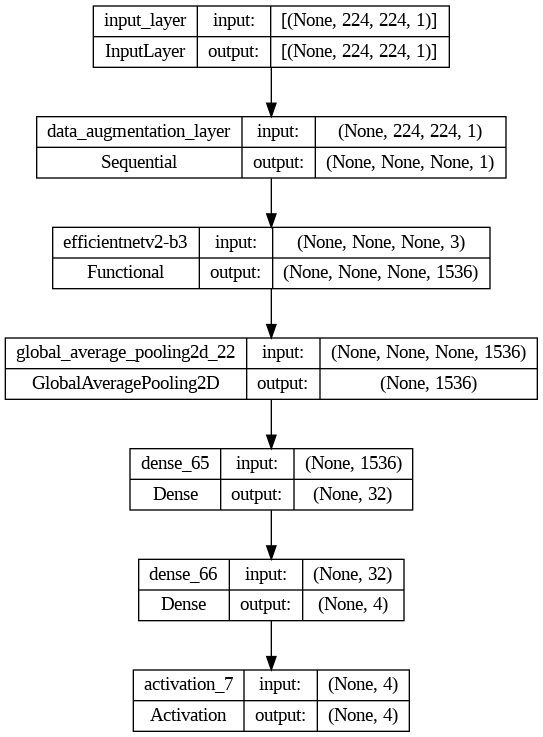

In [258]:
tf.keras.utils.plot_model(efficient_model, show_shapes=True)

In [259]:
efficient_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [260]:
efficient_history = efficient_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
239/239 [==============================] - 32s 82ms/step - loss: 0.7048 - accuracy: 0.7154 - val_loss: 0.7132 - val_accuracy: 0.6910 - lr: 0.0010
Epoch 2/20
239/239 [==============================] - 16s 65ms/step - loss: 0.5644 - accuracy: 0.7724 - val_loss: 0.8171 - val_accuracy: 0.6682 - lr: 0.0010
Epoch 3/20
239/239 [==============================] - 16s 66ms/step - loss: 0.5352 - accuracy: 0.7899 - val_loss: 0.6680 - val_accuracy: 0.7147 - lr: 0.0010
Epoch 4/20
239/239 [==============================] - 16s 66ms/step - loss: 0.5005 - accuracy: 0.7991 - val_loss: 0.6668 - val_accuracy: 0.7374 - lr: 0.0010
Epoch 5/20
239/239 [==============================] - 16s 65ms/step - loss: 0.4903 - accuracy: 0.8180 - val_loss: 0.5639 - val_accuracy: 0.7896 - lr: 0.0010
Epoch 6/20
239/239 [==============================] - 16s 66ms/step - loss: 0.4591 - accuracy: 0.8198 - val_loss: 0.5513 - val_accuracy: 0.7735 - lr: 0.0010
Epoch 7/20
239/239 [==============================] - 16s 

EfficientNetV2B3 Evaluation

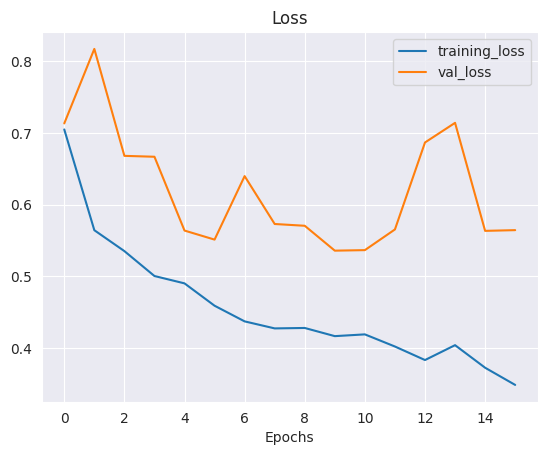

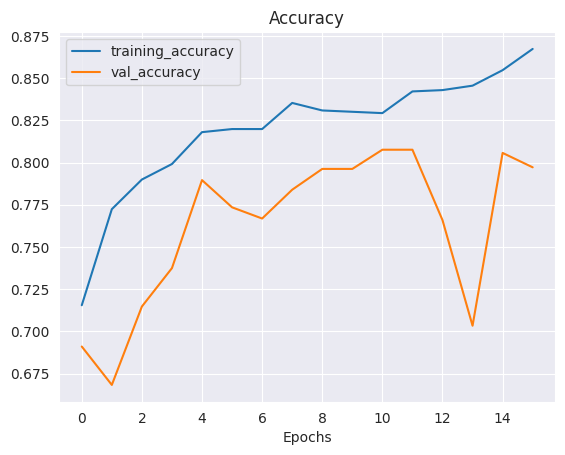

In [261]:
plot_loss_curves(efficient_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


40/40 [==============================] - 2s 42ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       158
           1       0.91      0.81      0.86       166
           2       0.93      0.52      0.67       154
           3       0.61      0.96      0.75       162

    accuracy                           0.79       640
   macro avg       0.84      0.79      0.79       640
weighted avg       0.84      0.79      0.79       640

Specificity: [0.27236580516898606, 0.26732673267326734, 0.14285714285714285, 0.32231404958677684]
Mean Squared Error: : 0.12807273864746094
The average AUC-ROC is 0.9585173693889394


[0.9570552147239264,
 0.6782077393075356,
 0.723826714801444,
 0.6321243523316062,
 0.6605316973415133,
 0.9368635437881874,
 0.7003610108303249,
 0.6502590673575129,
 0.7116564417177914,
 0.7067209775967414,
 0.8664259927797834,
 0.7331606217616581,
 0.6707566462167689,
 0.6782077393075356,
 0.7093862815884476,
 0.9844559585492227]

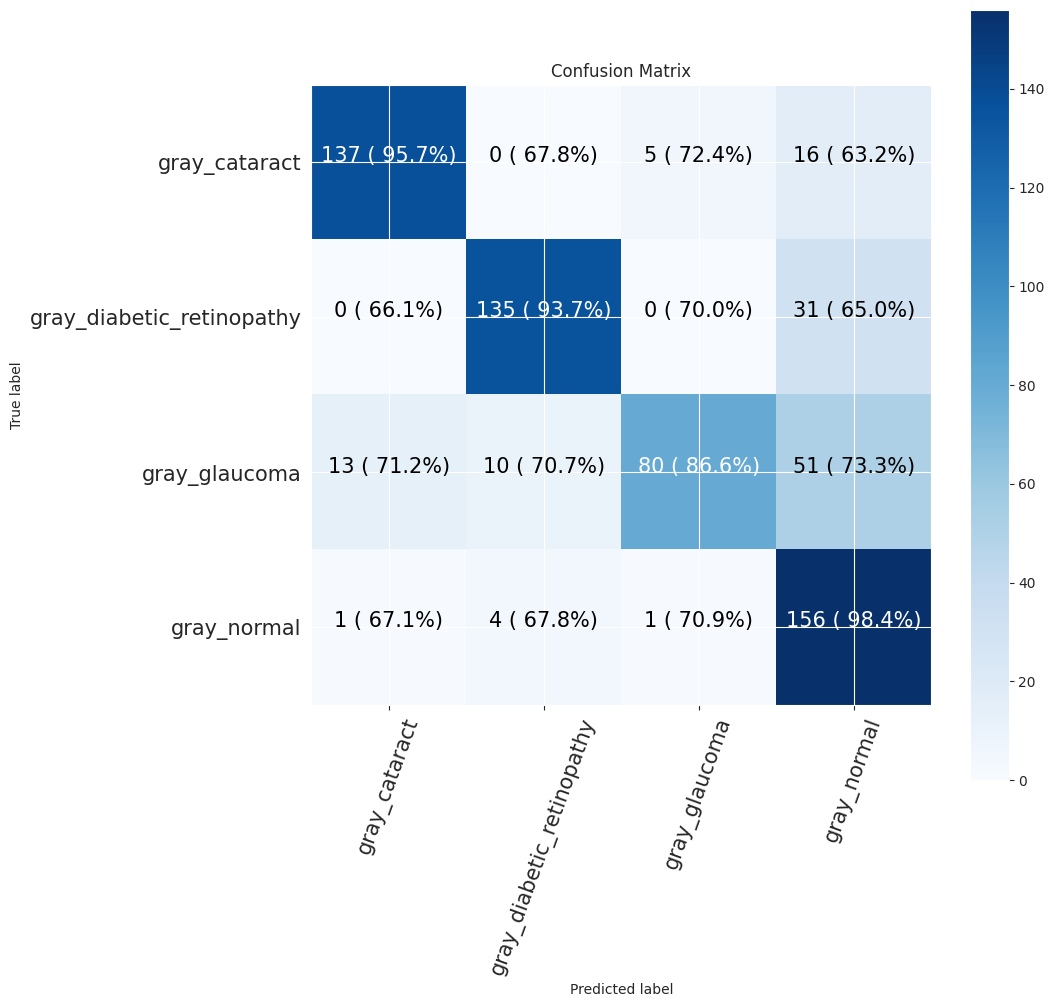

In [262]:
# Save Model
efficient_model.save("efficient_model.h5")

model = efficient_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]

pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels, pred_classes, classes=class_names, figsize=(10, 10))

# make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


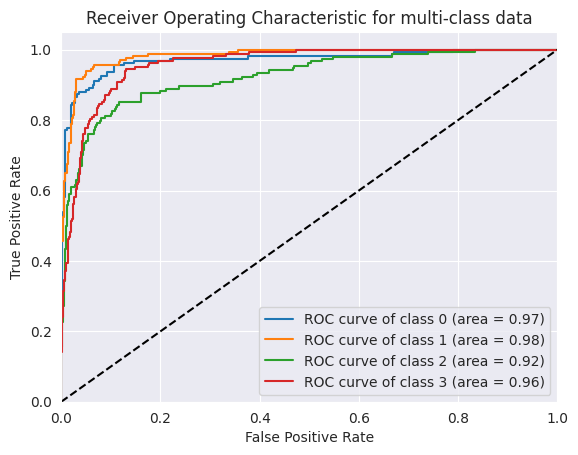

In [263]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **CNN model**

In [264]:

from tensorflow.keras.models import Sequential

# Create a Sequential model
cnn_model = Sequential()

# Add convolutional layers for feature extraction
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))  # Grayscale image has 1 channel

# Freeze the layers in the base model
for layer in cnn_model.layers:
    layer.trainable = False

grayscale_input = layers.Input(shape=(224, 224, 1))

grayscale_input = data_aug(grayscale_input)

cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for dense layers
cnn_model.add(layers.Flatten())

# Add dense layers for classification
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dense(4, activation='softmax'))  # Set num_classes to your specific number of classes

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
cnn_model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_43 (Conv2D)          (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_44 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_45 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 26, 26, 128)      

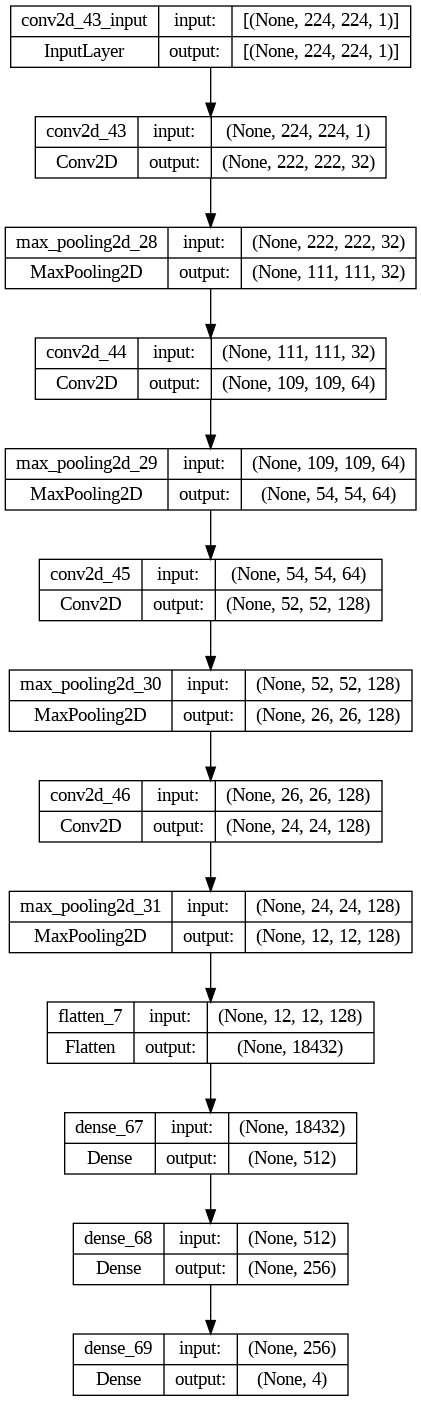

In [265]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [266]:
cnn_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [267]:
cnn_history = cnn_model.fit(train_data,epochs = epoch, validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
239/239 [==============================] - 8s 25ms/step - loss: 2.2338 - accuracy: 0.5146 - val_loss: 0.8106 - val_accuracy: 0.6313 - lr: 0.0010
Epoch 2/20
239/239 [==============================] - 5s 22ms/step - loss: 0.7428 - accuracy: 0.6488 - val_loss: 0.8175 - val_accuracy: 0.5611 - lr: 0.0010
Epoch 3/20
239/239 [==============================] - 5s 23ms/step - loss: 0.8358 - accuracy: 0.6473 - val_loss: 0.6898 - val_accuracy: 0.6957 - lr: 0.0010
Epoch 4/20
239/239 [==============================] - 5s 23ms/step - loss: 0.6765 - accuracy: 0.6994 - val_loss: 0.6264 - val_accuracy: 0.7280 - lr: 0.0010
Epoch 5/20
239/239 [==============================] - 6s 23ms/step - loss: 0.6129 - accuracy: 0.7186 - val_loss: 0.6101 - val_accuracy: 0.7185 - lr: 0.0010
Epoch 6/20
239/239 [==============================] - 5s 23ms/step - loss: 0.5965 - accuracy: 0.7317 - val_loss: 0.5973 - val_accuracy: 0.7270 - lr: 0.0010
Epoch 7/20
239/239 [==============================] - 6s 23ms/st

CNN Evaluation

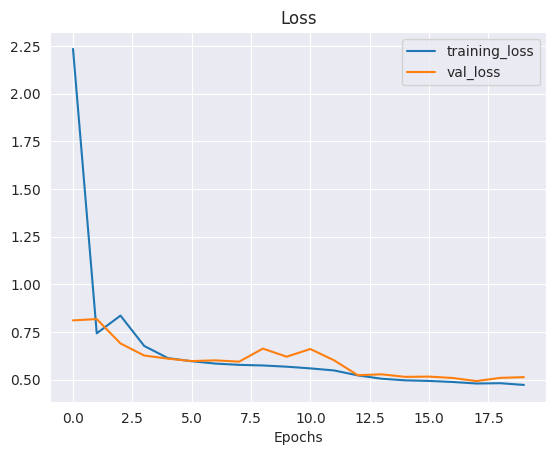

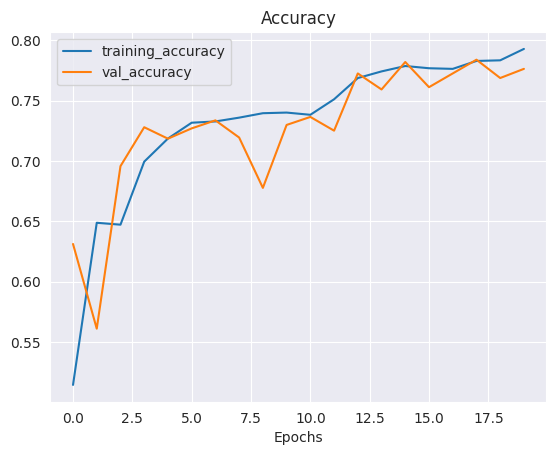

In [268]:
plot_loss_curves(cnn_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


40/40 [==============================] - 0s 8ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.55      0.61       158
           1       1.00      1.00      1.00       166
           2       0.66      0.55      0.60       154
           3       0.71      0.96      0.82       162

    accuracy                           0.77       640
   macro avg       0.77      0.77      0.76       640
weighted avg       0.77      0.77      0.76       640

Specificity: [0.15732368896925858, 0.350210970464135, 0.15315315315315314, 0.32231404958677684]
Mean Squared Error: : 0.13339389860630035
The average AUC-ROC is 0.9203029782695702


[0.8618677042801557,
 0.6666666666666666,
 0.763671875,
 0.7047619047619048,
 0.6770428015564203,
 1.0,
 0.67578125,
 0.6047619047619047,
 0.7762645914396887,
 0.6751054852320675,
 0.865234375,
 0.7047619047619048,
 0.6848249027237354,
 0.6582278481012658,
 0.6953125,
 0.9857142857142858]

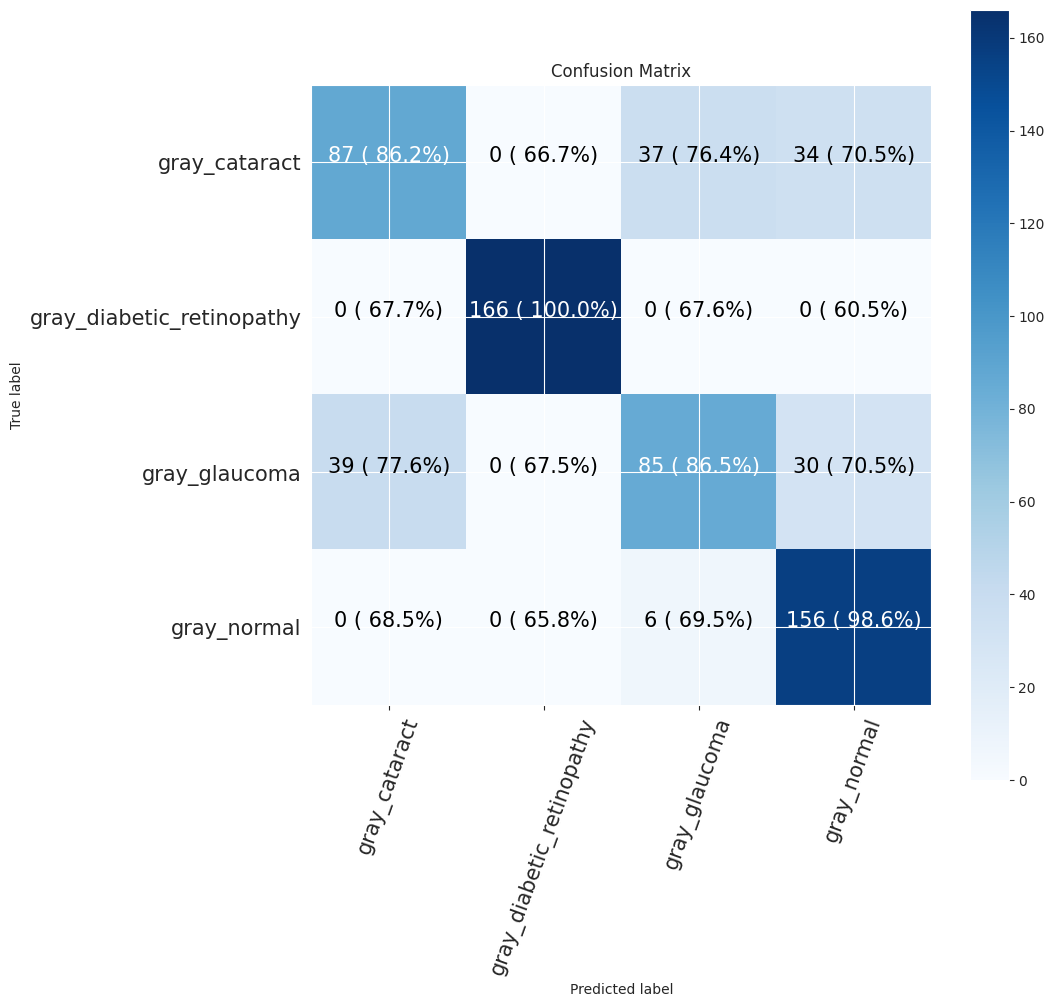

In [269]:
# Save Model
cnn_model.save("cnn_model.h5")

model = cnn_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


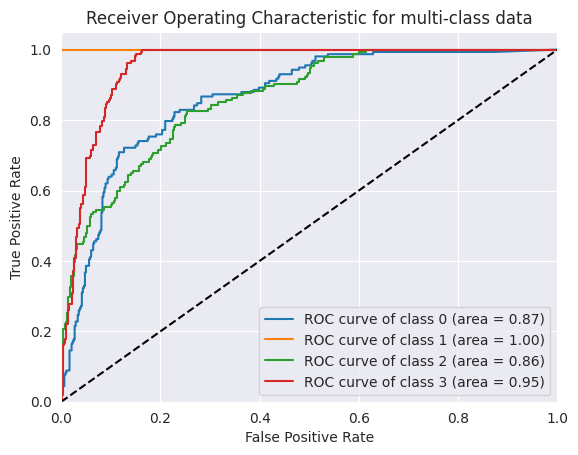

In [270]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet50 Model**



In [271]:
from tensorflow.keras.applications import ResNet50

# Load ResNet-50 without the top classification layers (include_top=False)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet50_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)
# Convert grayscale to 3 channels (matching the input requirement of ResNet-50)
conv_layer = Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-50 model
x = resnet50_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-50 model for grayscale images
resnet50_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet50_model.summary()


Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_64 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_47 (Conv2D)          (None, None, None, 3)     30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
 3 (GlobalAveragePooling2D)                                      
                                                                 
 dense_70 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_71 (Dense)            (None, 4)                 4100      
                                                          

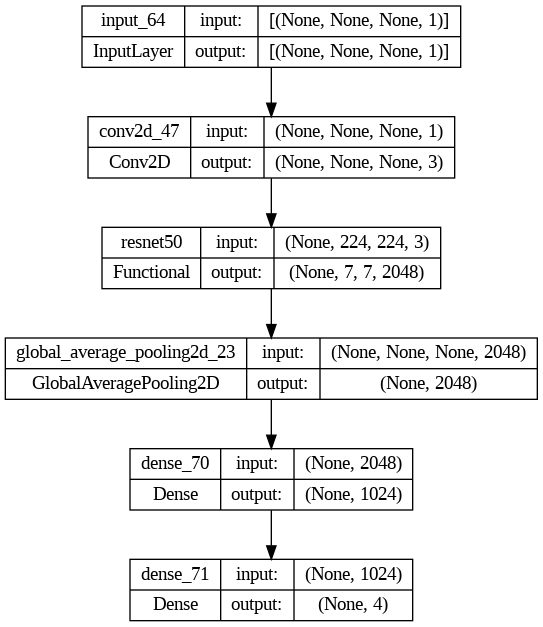

In [272]:
tf.keras.utils.plot_model(resnet50_model, show_shapes=True)

In [273]:
resnet50_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [274]:
resnet50_history = resnet50_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
239/239 [==============================] - 41s 154ms/step - loss: 0.6708 - accuracy: 0.7721 - val_loss: 0.3863 - val_accuracy: 0.8512 - lr: 0.0010
Epoch 2/20
239/239 [==============================] - 34s 143ms/step - loss: 0.3634 - accuracy: 0.8581 - val_loss: 0.4415 - val_accuracy: 0.8237 - lr: 0.0010
Epoch 3/20
239/239 [==============================] - 34s 143ms/step - loss: 0.2930 - accuracy: 0.8799 - val_loss: 0.5062 - val_accuracy: 0.7953 - lr: 0.0010
Epoch 4/20
239/239 [==============================] - 34s 144ms/step - loss: 0.2890 - accuracy: 0.8828 - val_loss: 0.2371 - val_accuracy: 0.9071 - lr: 0.0010
Epoch 5/20
239/239 [==============================] - 34s 143ms/step - loss: 0.2634 - accuracy: 0.8967 - val_loss: 0.2382 - val_accuracy: 0.9071 - lr: 0.0010
Epoch 6/20
239/239 [==============================] - 34s 143ms/step - loss: 0.2299 - accuracy: 0.9085 - val_loss: 0.2602 - val_accuracy: 0.8929 - lr: 0.0010
Epoch 7/20
239/239 [==============================] 

ResNet50 Evaluation

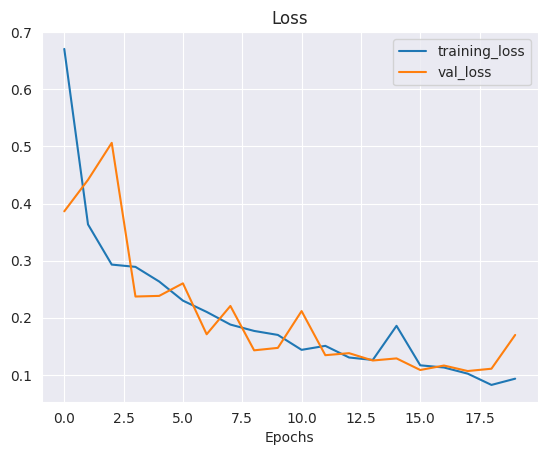

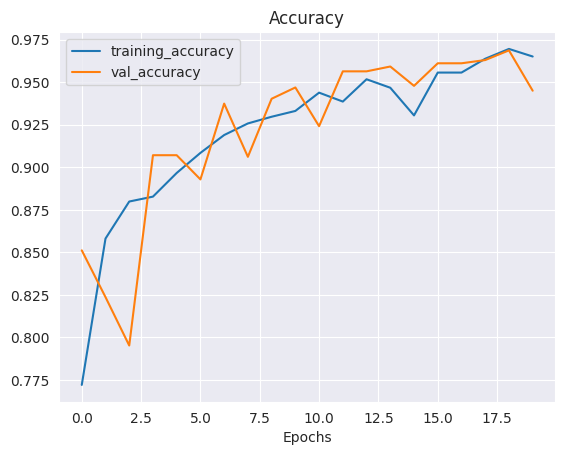

In [275]:
plot_loss_curves(resnet50_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


40/40 [==============================] - 2s 48ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.93       158
           1       0.97      0.99      0.98       166
           2       0.92      0.86      0.89       154
           3       0.85      0.94      0.90       162

    accuracy                           0.93       640
   macro avg       0.93      0.93      0.93       640
weighted avg       0.93      0.93      0.93       640

Specificity: [0.28772635814889336, 0.3473684210526316, 0.25984251968503935, 0.3141683778234086]
Mean Squared Error: : 0.10440844297409058
The average AUC-ROC is 0.9892276730173535


[0.9695121951219512,
 0.6659574468085107,
 0.6941649899396378,
 0.6746203904555315,
 0.6626016260162602,
 0.997872340425532,
 0.6659959758551308,
 0.6420824295010846,
 0.693089430894309,
 0.676595744680851,
 0.9557344064386318,
 0.702819956616052,
 0.6747967479674797,
 0.6595744680851063,
 0.6841046277665996,
 0.9804772234273319]

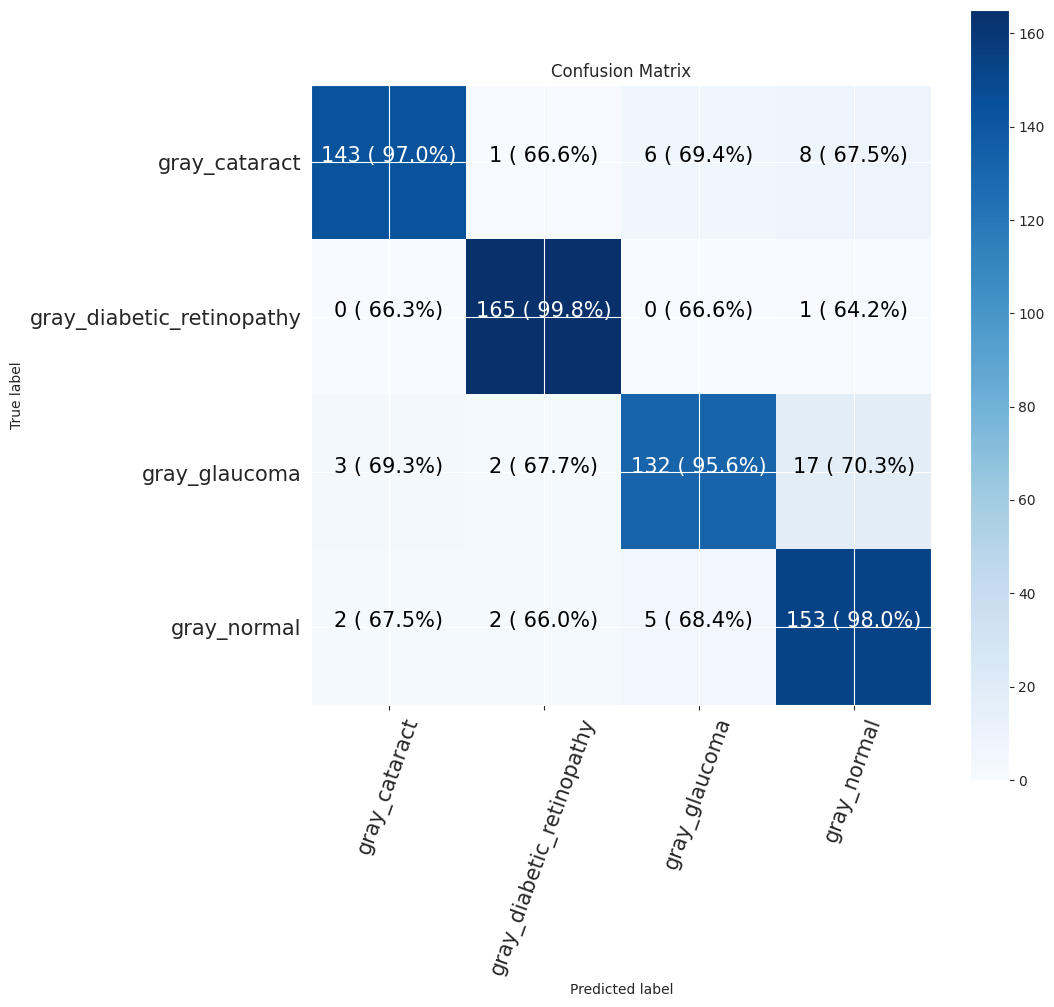

In [276]:
# Save Model
resnet50_model.save("resnet50_model.h5")

model = resnet50_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


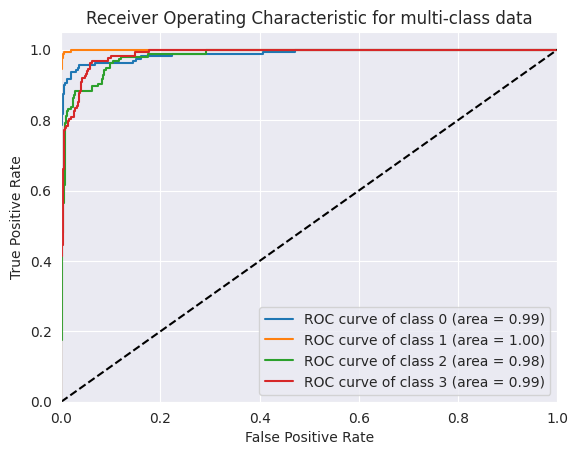

In [277]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet101**

In [278]:
from tensorflow.keras.applications import ResNet101

# Load ResNet-101 without the top classification layers (include_top=False)
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet101_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)

# Convert grayscale to 3 channels (matching the input requirement of ResNet-101)
conv_layer = layers.Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-101 model
x = resnet101_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-101 model for grayscale images
resnet101_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet101_model.summary()


Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_67 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_48 (Conv2D)          (None, None, None, 3)     30        
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
 4 (GlobalAveragePooling2D)                                      
                                                                 
 dense_72 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_73 (Dense)            (None, 4)                 4100      
                                                          

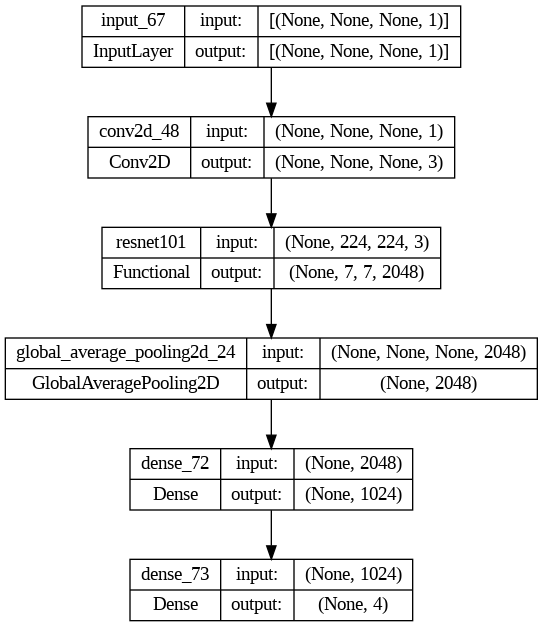

In [279]:
tf.keras.utils.plot_model(resnet101_model, show_shapes=True)

In [280]:
resnet101_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [281]:
resnet101_history= resnet101_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
239/239 [==============================] - 67s 248ms/step - loss: 0.6676 - accuracy: 0.7745 - val_loss: 0.4346 - val_accuracy: 0.8370 - lr: 0.0010
Epoch 2/20
239/239 [==============================] - 57s 236ms/step - loss: 0.4117 - accuracy: 0.8332 - val_loss: 0.3141 - val_accuracy: 0.8749 - lr: 0.0010
Epoch 3/20
239/239 [==============================] - 57s 237ms/step - loss: 0.3167 - accuracy: 0.8799 - val_loss: 0.3330 - val_accuracy: 0.8701 - lr: 0.0010
Epoch 4/20
239/239 [==============================] - 57s 237ms/step - loss: 0.2789 - accuracy: 0.8904 - val_loss: 0.2839 - val_accuracy: 0.8967 - lr: 0.0010
Epoch 5/20
239/239 [==============================] - 57s 237ms/step - loss: 0.2384 - accuracy: 0.9085 - val_loss: 0.2077 - val_accuracy: 0.9232 - lr: 0.0010
Epoch 6/20
239/239 [==============================] - 57s 237ms/step - loss: 0.2179 - accuracy: 0.9148 - val_loss: 0.2128 - val_accuracy: 0.9118 - lr: 0.0010
Epoch 7/20
239/239 [==============================] 

ResNet101 Evaluation

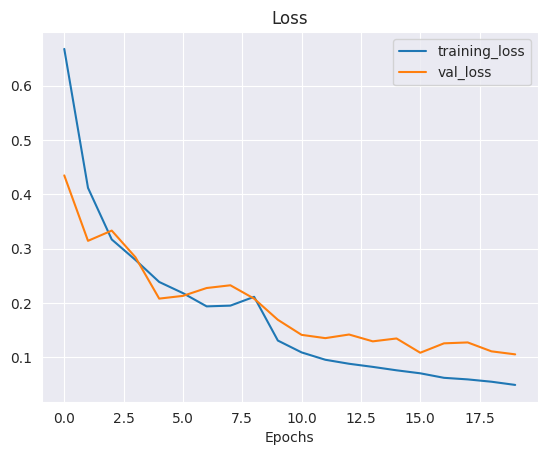

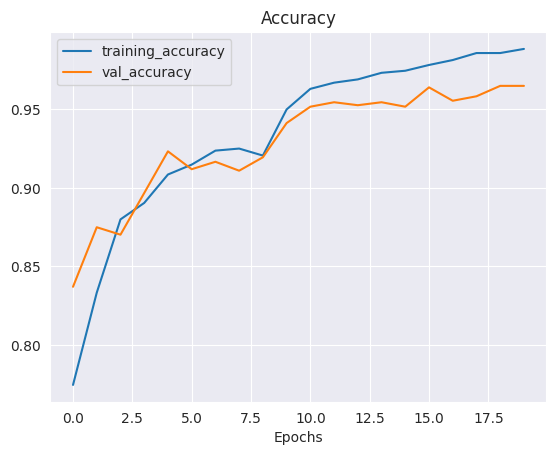

In [282]:
plot_loss_curves(resnet101_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


40/40 [==============================] - 3s 82ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       158
           1       0.99      0.98      0.98       166
           2       0.91      0.84      0.87       154
           3       0.85      0.94      0.90       162

    accuracy                           0.92       640
   macro avg       0.92      0.92      0.92       640
weighted avg       0.92      0.92      0.92       640

Specificity: [0.285140562248996, 0.3417190775681342, 0.25244618395303325, 0.3141683778234086]
Mean Squared Error: : 0.10467547923326492
The average AUC-ROC is 0.9901530483480843


[0.9670781893004116,
 0.6673684210526316,
 0.6987951807228916,
 0.6746203904555315,
 0.6584362139917695,
 0.9936842105263158,
 0.6686746987951807,
 0.6442516268980477,
 0.6995884773662552,
 0.6778947368421052,
 0.9497991967871486,
 0.7006507592190889,
 0.6748971193415638,
 0.6610526315789473,
 0.6827309236947792,
 0.9804772234273319]

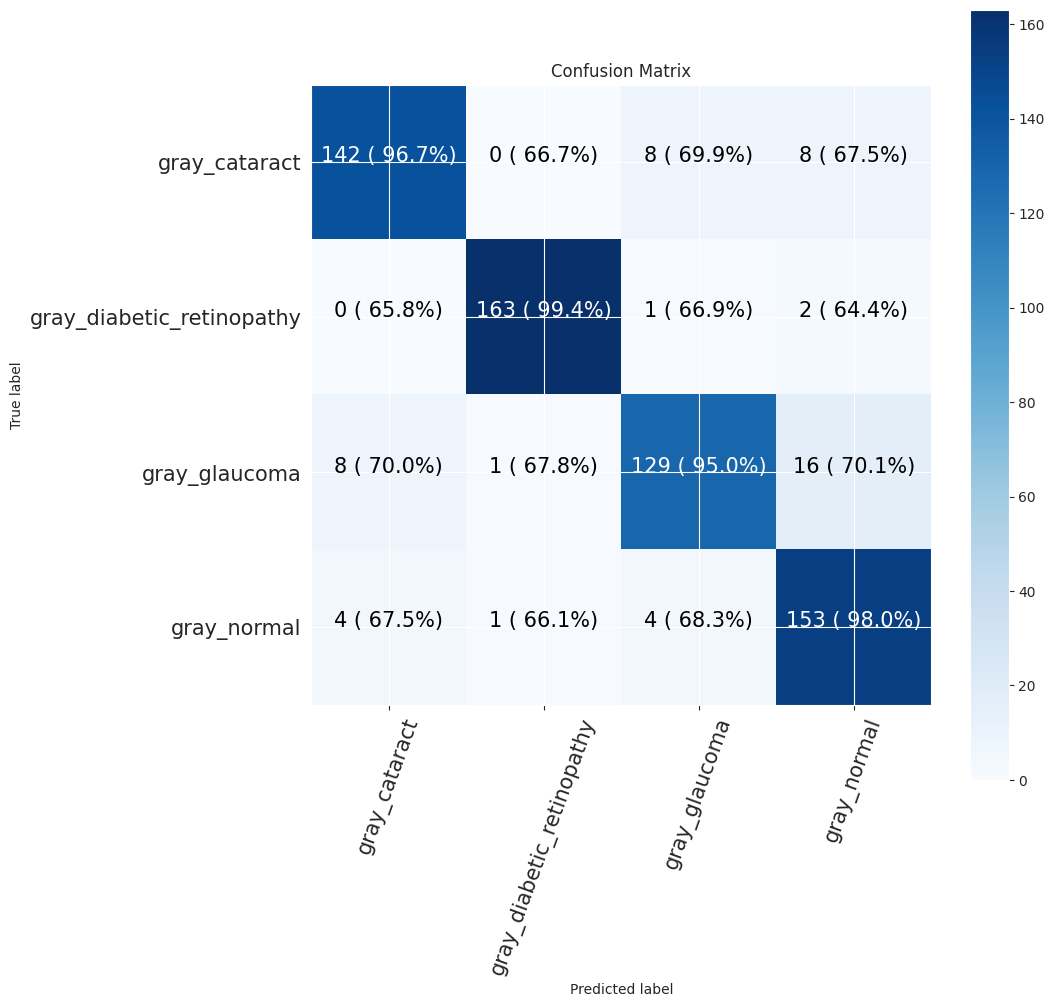

In [283]:
# Save Model
resnet101_model.save("resnet101_model.h5")

model = resnet101_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


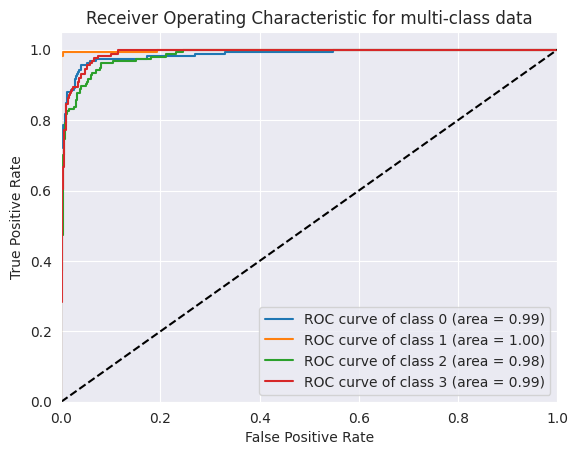

In [284]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **Batch size: 32**

In [285]:
epoch = 20
batchsize = 32

In [286]:
train_dir = "outputgrayscale/train"
test_dir =  "outputgrayscale/test"
val_dir = "outputgrayscale/val"

train_classes = sorted([name for name in os.listdir(train_dir)])
class_names = train_classes  # Assuming class names are the same across train, test, and val

# Load datasets
train_data = image_dataset_from_directory(train_dir, label_mode="categorical",
                                          image_size=(224, 224), batch_size=batchsize,
                                          shuffle=True, seed=42, color_mode='grayscale')

test_data = image_dataset_from_directory(test_dir, label_mode="categorical",
                                         image_size=(224, 224), batch_size=batchsize,
                                         shuffle=False, seed=42, color_mode='grayscale')

val_data = image_dataset_from_directory(val_dir, label_mode="categorical",
                                        image_size=(224, 224), batch_size=batchsize,
                                        shuffle=False, seed=42, color_mode='grayscale')


Found 3813 files belonging to 4 classes.
Found 640 files belonging to 4 classes.
Found 1055 files belonging to 4 classes.


In [287]:
train_data = train_data.map(lambda x, y: (sharpen_image(x), y))
test_data = test_data.map(lambda x, y: (sharpen_image(x), y))
val_data = val_data.map(lambda x, y: (sharpen_image(x), y))

# **EfficientNetV2B3 Model**

In [288]:
efficient_model = tf.keras.applications.EfficientNetV2B3(include_top = False)
efficient_model.trainable = False


In [289]:
inputs = layers.Input(shape=(224, 224, 1), name="input_layer")
x = data_aug(inputs)
# x = inputs
x = efficient_model(x)

# Apply Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.Dense(4)(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)

efficient_model = tf.keras.Model(inputs, outputs)
efficient_model.summary()

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 1)]     0         
                                                                 
 data_augmentation_layer (S  (None, None, None, 1)     0         
 equential)                                                      
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d_2  (None, 1536)              0         
 5 (GlobalAveragePooling2D)                                      
                                                                 
 dense_74 (Dense)            (None, 32)                49184     
                                                          

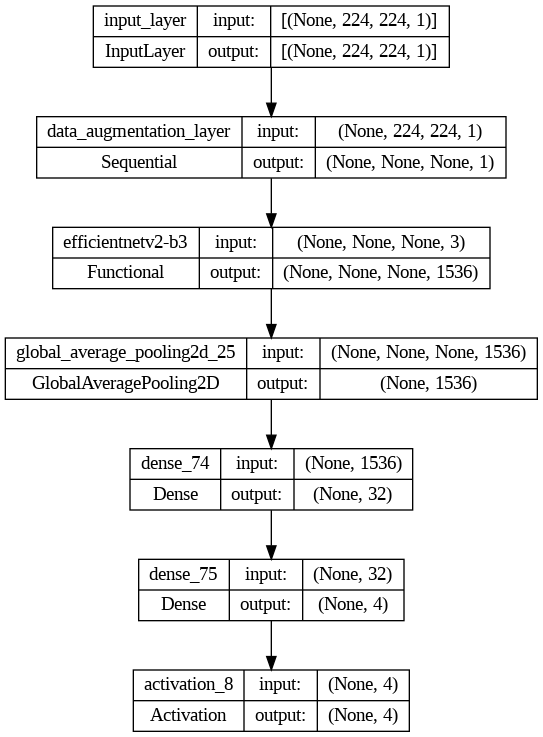

In [290]:
tf.keras.utils.plot_model(efficient_model, show_shapes=True)

In [291]:
efficient_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [292]:
efficient_history = efficient_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
120/120 [==============================] - 30s 155ms/step - loss: 0.7161 - accuracy: 0.7076 - val_loss: 0.7744 - val_accuracy: 0.6616 - lr: 0.0010
Epoch 2/20
120/120 [==============================] - 14s 118ms/step - loss: 0.5612 - accuracy: 0.7842 - val_loss: 0.8467 - val_accuracy: 0.6218 - lr: 0.0010
Epoch 3/20
120/120 [==============================] - 14s 119ms/step - loss: 0.5215 - accuracy: 0.7905 - val_loss: 0.6762 - val_accuracy: 0.7336 - lr: 0.0010
Epoch 4/20
120/120 [==============================] - 15s 120ms/step - loss: 0.4945 - accuracy: 0.8067 - val_loss: 0.8165 - val_accuracy: 0.7043 - lr: 0.0010
Epoch 5/20
120/120 [==============================] - 14s 119ms/step - loss: 0.4894 - accuracy: 0.8088 - val_loss: 0.5851 - val_accuracy: 0.7640 - lr: 0.0010
Epoch 6/20
120/120 [==============================] - 15s 120ms/step - loss: 0.4632 - accuracy: 0.8206 - val_loss: 0.6236 - val_accuracy: 0.7678 - lr: 0.0010
Epoch 7/20
120/120 [==============================] 

EfficientNetV2B3 Evaluation

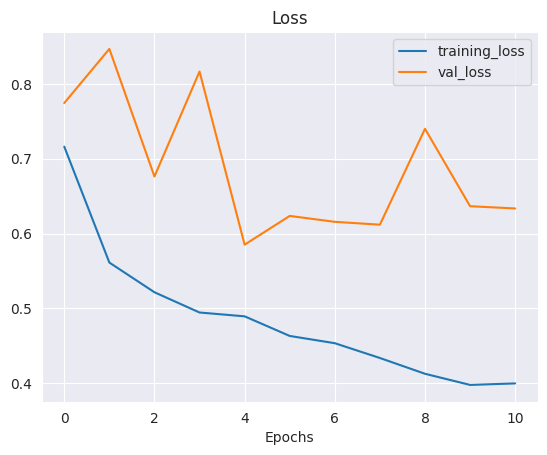

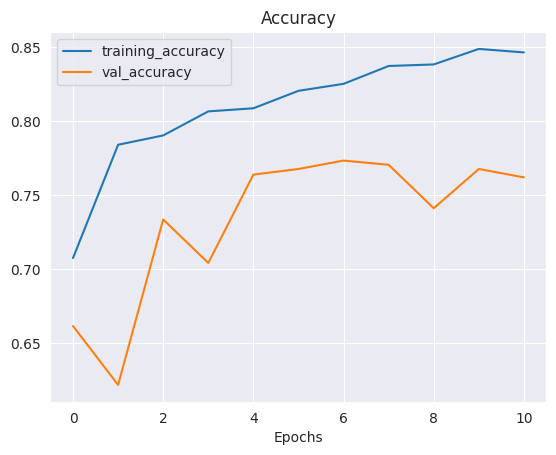

In [293]:
plot_loss_curves(efficient_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 2s 77ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       158
           1       0.86      0.78      0.82       166
           2       0.96      0.48      0.64       154
           3       0.60      0.91      0.72       162

    accuracy                           0.77       640
   macro avg       0.82      0.76      0.76       640
weighted avg       0.81      0.77      0.76       640

Specificity: [0.2774451097804391, 0.2549019607843137, 0.13074204946996468, 0.3008130081300813]
Mean Squared Error: : 0.1323210448026657
The average AUC-ROC is 0.9458461048691001


[0.96,
 0.6768916155419223,
 0.7229129662522202,
 0.6412213740458015,
 0.6526315789473685,
 0.9263803680981595,
 0.7051509769094139,
 0.6666666666666666,
 0.7221052631578947,
 0.7075664621676891,
 0.8579040852575488,
 0.727735368956743,
 0.6652631578947369,
 0.689161554192229,
 0.7140319715808171,
 0.9643765903307888]

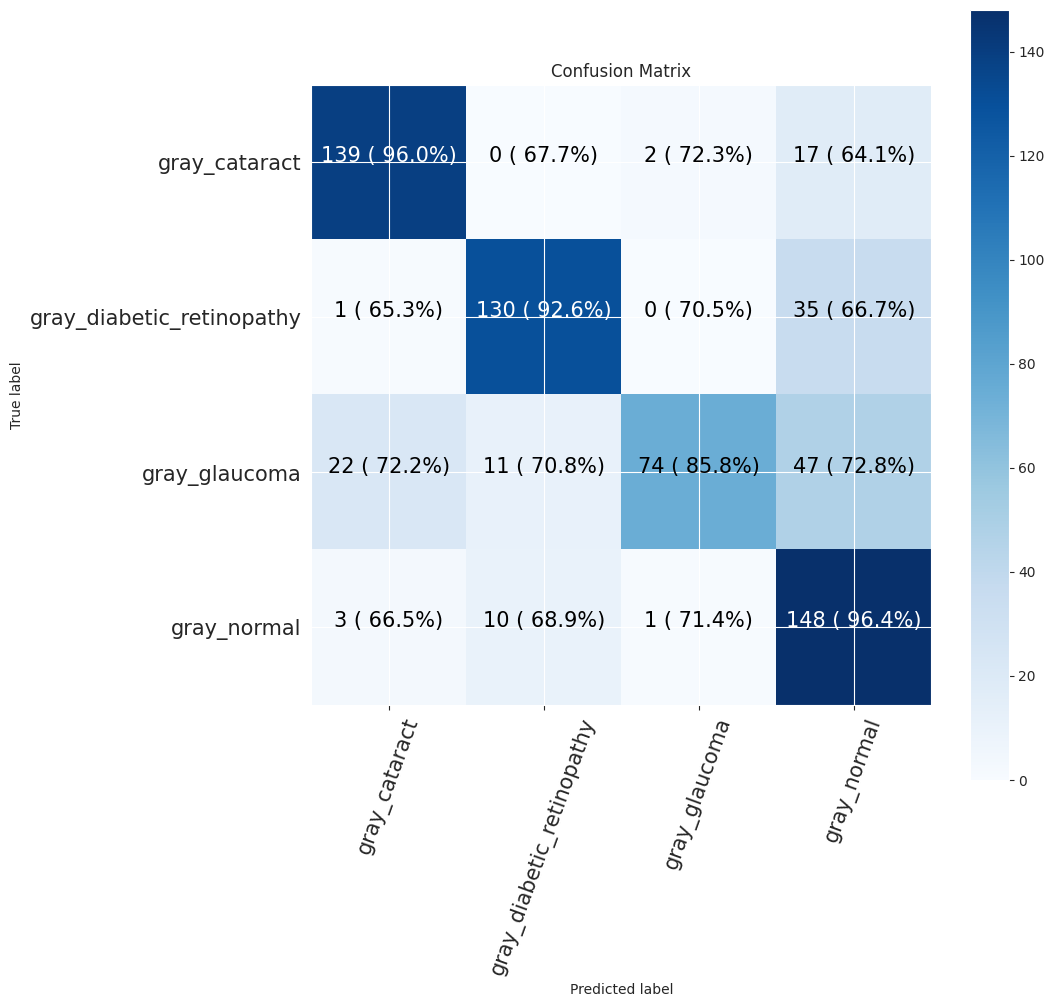

In [294]:
# Save Model
efficient_model.save("efficient_model.h5")

model = efficient_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


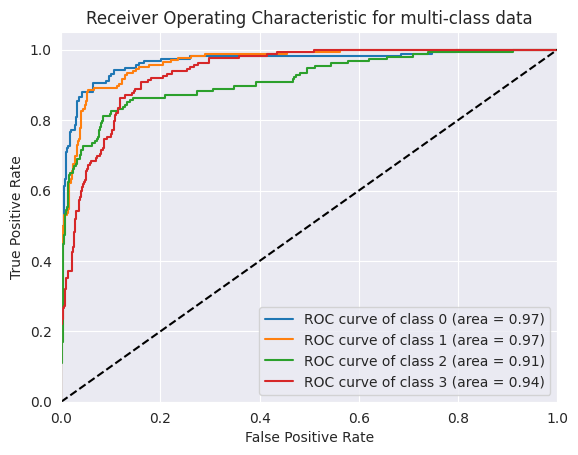

In [295]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **CNN model**

In [296]:
from tensorflow.keras.models import Sequential

# Create a Sequential model
cnn_model = Sequential()

# Add convolutional layers for feature extraction
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))  # Grayscale image has 1 channel

# Freeze the layers in the base model
for layer in cnn_model.layers:
    layer.trainable = False

grayscale_input = layers.Input(shape=(224, 224, 1))

grayscale_input = data_aug(grayscale_input)

cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for dense layers
cnn_model.add(layers.Flatten())

# Add dense layers for classification
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dense(4, activation='softmax'))  # Set num_classes to your specific number of classes

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
cnn_model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_49 (Conv2D)          (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_50 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_51 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 26, 26, 128)      

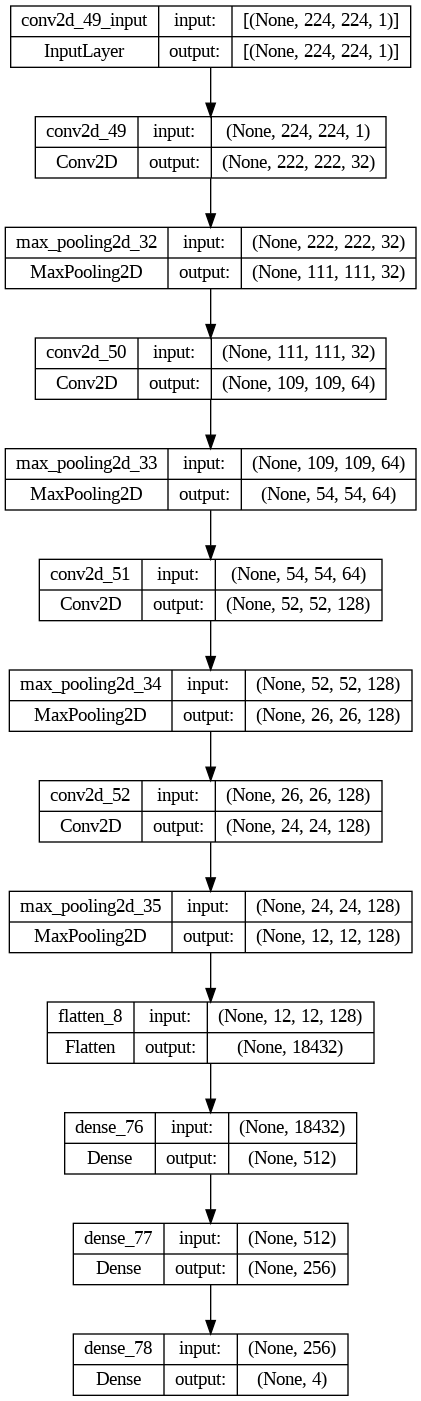

In [297]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [298]:
cnn_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [299]:
cnn_history = cnn_model.fit(train_data,epochs = epoch, validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
120/120 [==============================] - 7s 43ms/step - loss: 3.8716 - accuracy: 0.4831 - val_loss: 0.9384 - val_accuracy: 0.5526 - lr: 0.0010
Epoch 2/20
120/120 [==============================] - 5s 37ms/step - loss: 0.8256 - accuracy: 0.5799 - val_loss: 0.7523 - val_accuracy: 0.6550 - lr: 0.0010
Epoch 3/20
120/120 [==============================] - 5s 37ms/step - loss: 0.7388 - accuracy: 0.6313 - val_loss: 0.7187 - val_accuracy: 0.6768 - lr: 0.0010
Epoch 4/20
120/120 [==============================] - 5s 37ms/step - loss: 0.6799 - accuracy: 0.6874 - val_loss: 0.7069 - val_accuracy: 0.6682 - lr: 0.0010
Epoch 5/20
120/120 [==============================] - 5s 37ms/step - loss: 0.6576 - accuracy: 0.6966 - val_loss: 0.6767 - val_accuracy: 0.7185 - lr: 0.0010
Epoch 6/20
120/120 [==============================] - 5s 37ms/step - loss: 0.6365 - accuracy: 0.7039 - val_loss: 0.6116 - val_accuracy: 0.7147 - lr: 0.0010
Epoch 7/20
120/120 [==============================] - 5s 37ms/st

CNN Evaluation

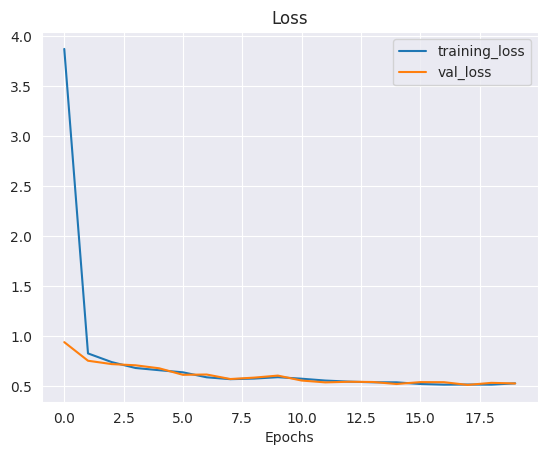

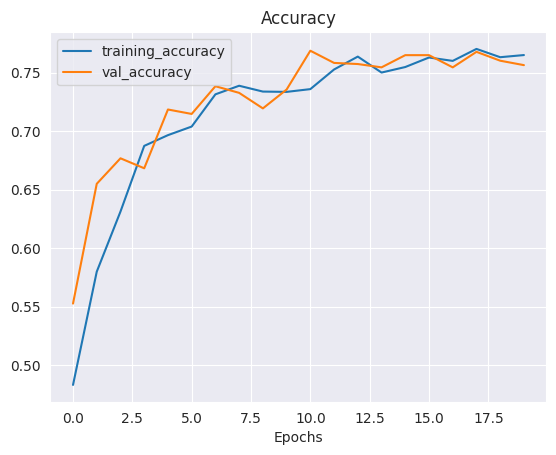

In [300]:
plot_loss_curves(cnn_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 0s 13ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.59      0.62       158
           1       0.99      1.00      0.99       166
           2       0.68      0.49      0.57       154
           3       0.70      0.94      0.80       162

    accuracy                           0.76       640
   macro avg       0.75      0.76      0.75       640
weighted avg       0.76      0.76      0.75       640

Specificity: [0.170018281535649, 0.350210970464135, 0.13274336283185842, 0.3141683778234086]
Mean Squared Error: : 0.13572536408901215
The average AUC-ROC is 0.9234446540077432


[0.869215291750503,
 0.6673728813559322,
 0.7584905660377359,
 0.7054631828978623,
 0.6659959758551308,
 1.0,
 0.6867924528301886,
 0.6057007125890737,
 0.7847082494969819,
 0.673728813559322,
 0.8509433962264151,
 0.7102137767220903,
 0.6800804828973843,
 0.6588983050847458,
 0.7037735849056603,
 0.9786223277909739]

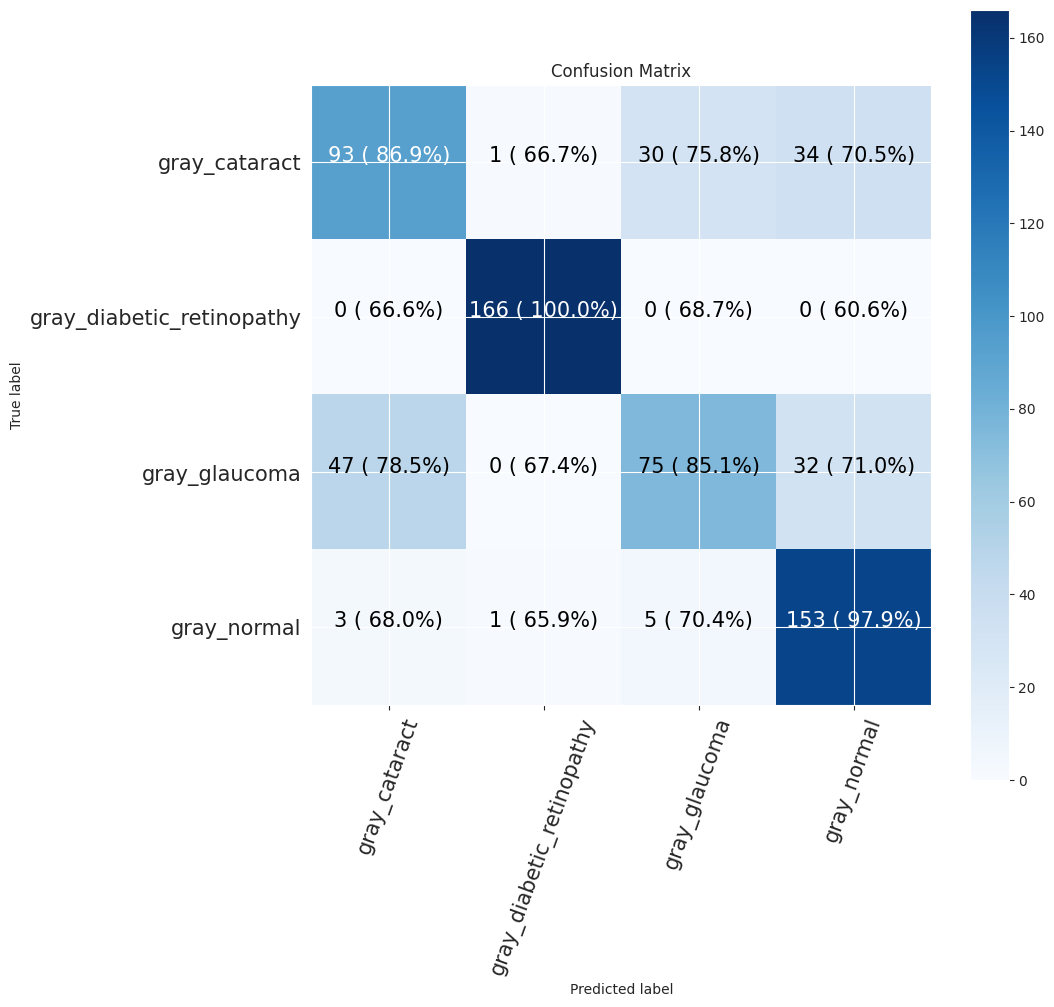

In [301]:
# Save Model
cnn_model.save("cnn_model.h5")

model = cnn_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


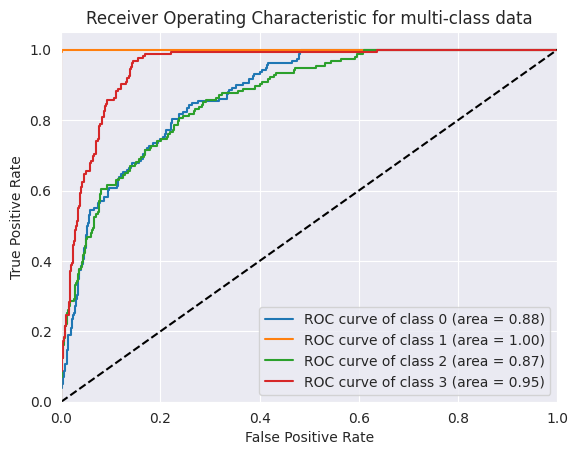

In [302]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet50 Model**



In [303]:
from tensorflow.keras.applications import ResNet50

# Load ResNet-50 without the top classification layers (include_top=False)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet50_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)
# Convert grayscale to 3 channels (matching the input requirement of ResNet-50)
conv_layer = Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-50 model
x = resnet50_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-50 model for grayscale images
resnet50_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet50_model.summary()


Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_72 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_53 (Conv2D)          (None, None, None, 3)     30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
 6 (GlobalAveragePooling2D)                                      
                                                                 
 dense_79 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_80 (Dense)            (None, 4)                 4100      
                                                          

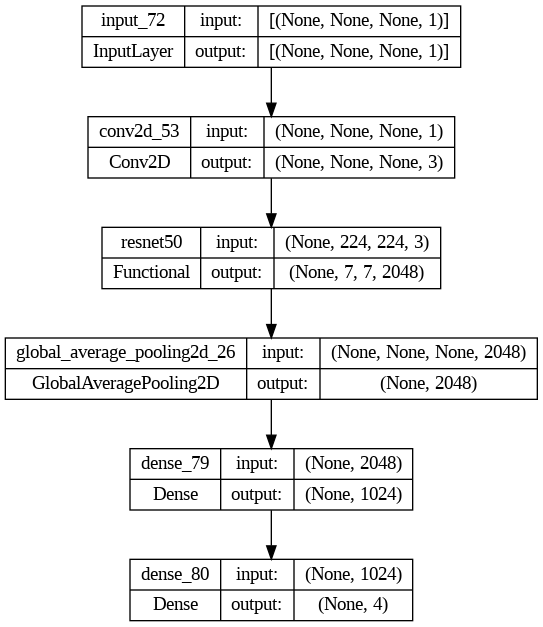

In [304]:
tf.keras.utils.plot_model(resnet50_model, show_shapes=True)

In [305]:
resnet50_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [306]:
resnet50_history = resnet50_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
120/120 [==============================] - 40s 300ms/step - loss: 0.6089 - accuracy: 0.7831 - val_loss: 0.3582 - val_accuracy: 0.8692 - lr: 0.0010
Epoch 2/20
120/120 [==============================] - 33s 273ms/step - loss: 0.3494 - accuracy: 0.8673 - val_loss: 0.2863 - val_accuracy: 0.8929 - lr: 0.0010
Epoch 3/20
120/120 [==============================] - 33s 272ms/step - loss: 0.2962 - accuracy: 0.8864 - val_loss: 0.2558 - val_accuracy: 0.9071 - lr: 0.0010
Epoch 4/20
120/120 [==============================] - 33s 274ms/step - loss: 0.2499 - accuracy: 0.9027 - val_loss: 0.1927 - val_accuracy: 0.9223 - lr: 0.0010
Epoch 5/20
120/120 [==============================] - 33s 272ms/step - loss: 0.2076 - accuracy: 0.9187 - val_loss: 0.2684 - val_accuracy: 0.8986 - lr: 0.0010
Epoch 6/20
120/120 [==============================] - 33s 273ms/step - loss: 0.1975 - accuracy: 0.9242 - val_loss: 0.1556 - val_accuracy: 0.9393 - lr: 0.0010
Epoch 7/20
120/120 [==============================] 

ResNet50 Evaluation

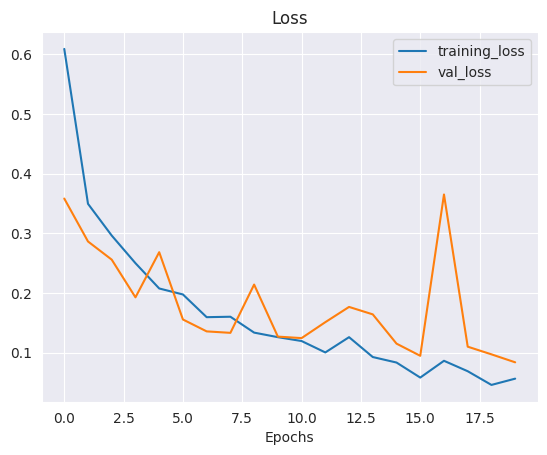

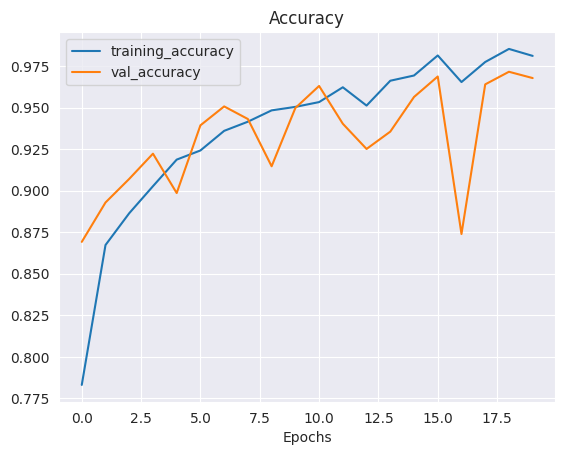

In [307]:
plot_loss_curves(resnet50_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 2s 90ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       158
           1       0.98      1.00      0.99       166
           2       0.93      0.84      0.88       154
           3       0.87      0.92      0.89       162

    accuracy                           0.93       640
   macro avg       0.93      0.93      0.93       640
weighted avg       0.93      0.93      0.93       640

Specificity: [0.3008130081300813, 0.350210970464135, 0.2549019607843137, 0.3034623217922607]
Mean Squared Error: : 0.1030026450753212
The average AUC-ROC is 0.992358108516672


[0.9792099792099792,
 0.6645435244161358,
 0.688,
 0.6794871794871795,
 0.6548856548856549,
 1.0,
 0.668,
 0.6452991452991453,
 0.6943866943866944,
 0.6772823779193206,
 0.952,
 0.7029914529914529,
 0.6715176715176715,
 0.6581740976645435,
 0.692,
 0.9722222222222222]

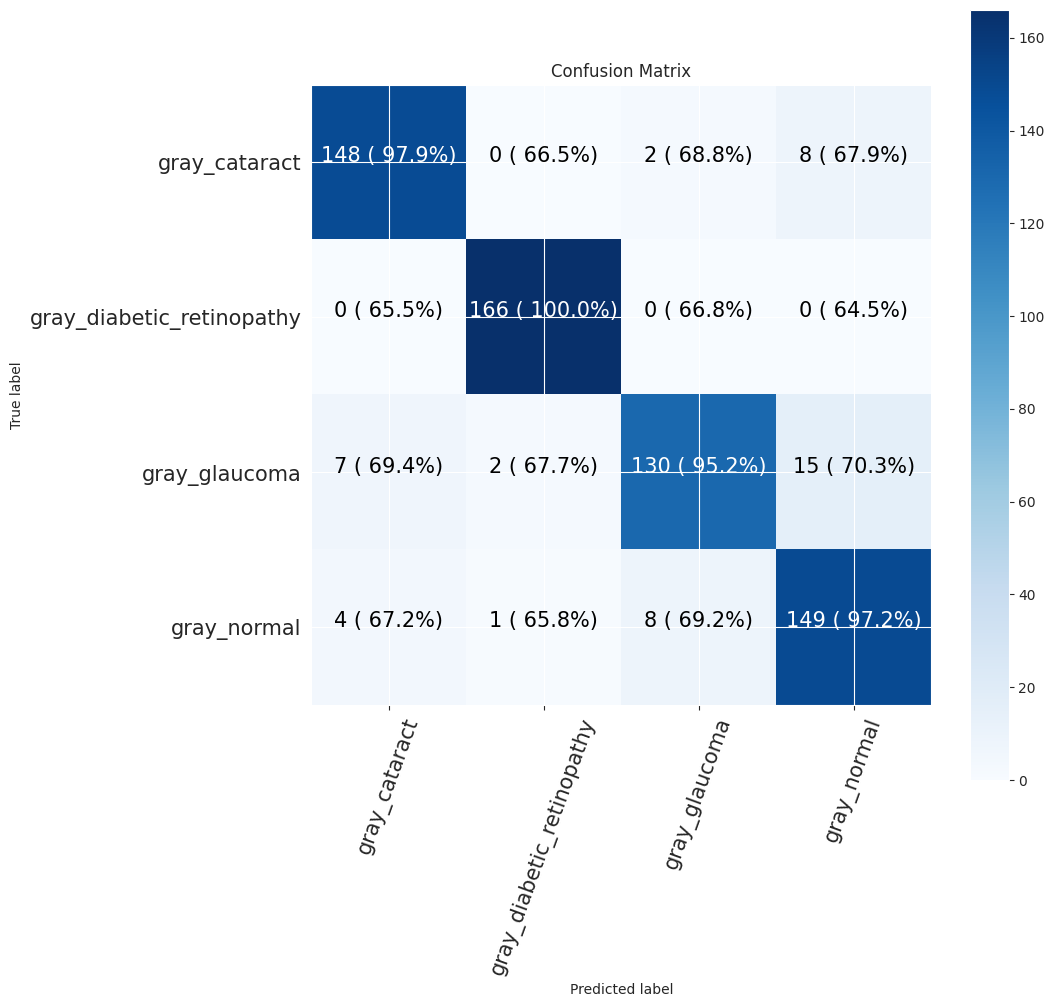

In [308]:
# Save Model
resnet50_model.save("resnet50_model.h5")

model = resnet50_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


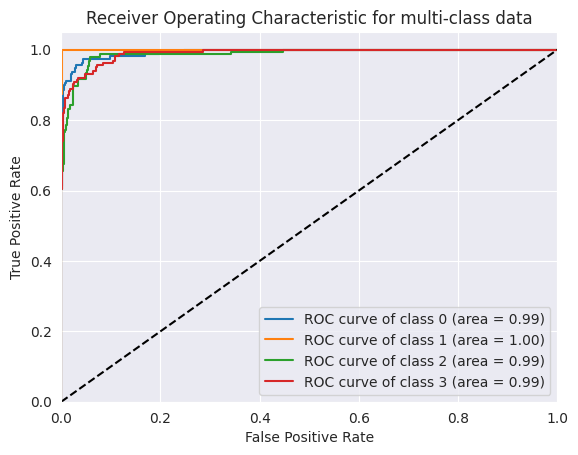

In [309]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet101**

In [310]:
from tensorflow.keras.applications import ResNet101

# Load ResNet-101 without the top classification layers (include_top=False)
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet101_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)

# Convert grayscale to 3 channels (matching the input requirement of ResNet-101)
conv_layer = layers.Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-101 model
x = resnet101_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-101 model for grayscale images
resnet101_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet101_model.summary()


Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_75 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_54 (Conv2D)          (None, None, None, 3)     30        
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
 7 (GlobalAveragePooling2D)                                      
                                                                 
 dense_81 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_82 (Dense)            (None, 4)                 4100      
                                                          

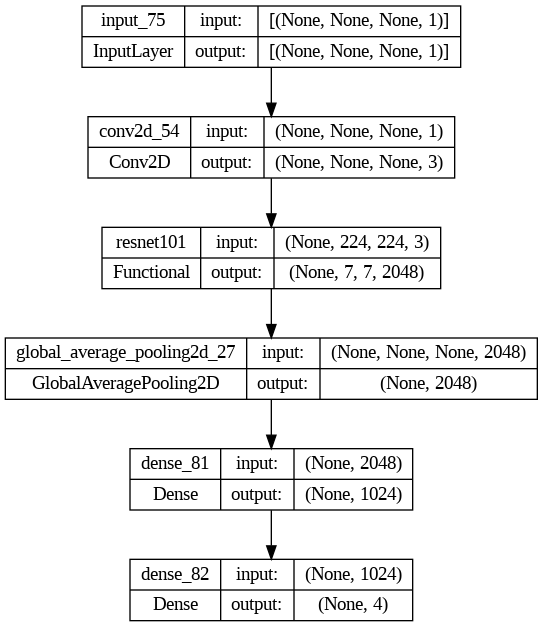

In [311]:
tf.keras.utils.plot_model(resnet101_model, show_shapes=True)

In [312]:
resnet101_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [313]:
resnet101_history= resnet101_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
120/120 [==============================] - 64s 472ms/step - loss: 0.7407 - accuracy: 0.7522 - val_loss: 0.7191 - val_accuracy: 0.6806 - lr: 0.0010
Epoch 2/20
120/120 [==============================] - 54s 450ms/step - loss: 0.4004 - accuracy: 0.8426 - val_loss: 0.3553 - val_accuracy: 0.8521 - lr: 0.0010
Epoch 3/20
120/120 [==============================] - 54s 452ms/step - loss: 0.3083 - accuracy: 0.8880 - val_loss: 0.3017 - val_accuracy: 0.8891 - lr: 0.0010
Epoch 4/20
120/120 [==============================] - 54s 451ms/step - loss: 0.2558 - accuracy: 0.9030 - val_loss: 0.3610 - val_accuracy: 0.8493 - lr: 0.0010
Epoch 5/20
120/120 [==============================] - 54s 450ms/step - loss: 0.2454 - accuracy: 0.9056 - val_loss: 0.2491 - val_accuracy: 0.9014 - lr: 0.0010
Epoch 6/20
120/120 [==============================] - 54s 452ms/step - loss: 0.2259 - accuracy: 0.9127 - val_loss: 0.2172 - val_accuracy: 0.9156 - lr: 0.0010
Epoch 7/20
120/120 [==============================] 

ResNet101 Evaluation

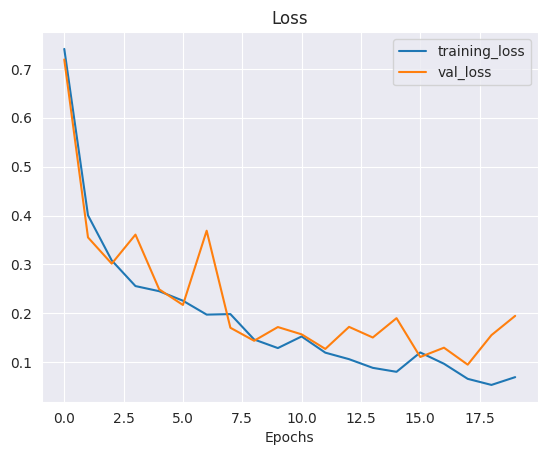

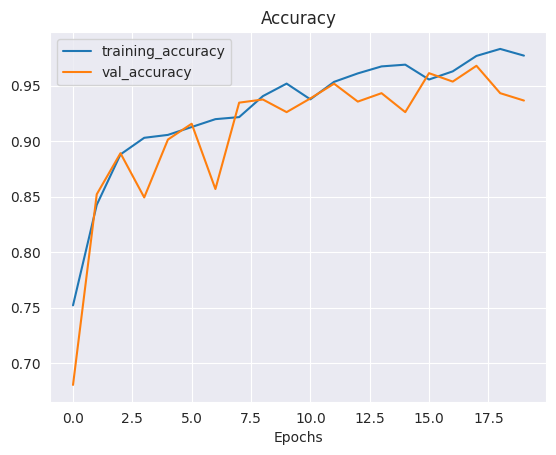

In [314]:
plot_loss_curves(resnet101_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 3s 158ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       158
           1       1.00      0.99      0.99       166
           2       0.97      0.73      0.83       154
           3       0.78      0.98      0.87       162

    accuracy                           0.91       640
   macro avg       0.92      0.91      0.91       640
weighted avg       0.92      0.91      0.91       640

Specificity: [0.29554655870445345, 0.3445378151260504, 0.21212121212121213, 0.3305613305613306]
Mean Squared Error: : 0.10707732290029526
The average AUC-ROC is 0.9862645048314248


[0.9751552795031055,
 0.6680672268907563,
 0.7028571428571428,
 0.6605504587155964,
 0.6563146997929606,
 0.9957983193277311,
 0.6838095238095238,
 0.6238532110091743,
 0.6997929606625258,
 0.6764705882352942,
 0.92,
 0.7224770642201835,
 0.6687370600414079,
 0.6596638655462185,
 0.6933333333333334,
 0.9931192660550459]

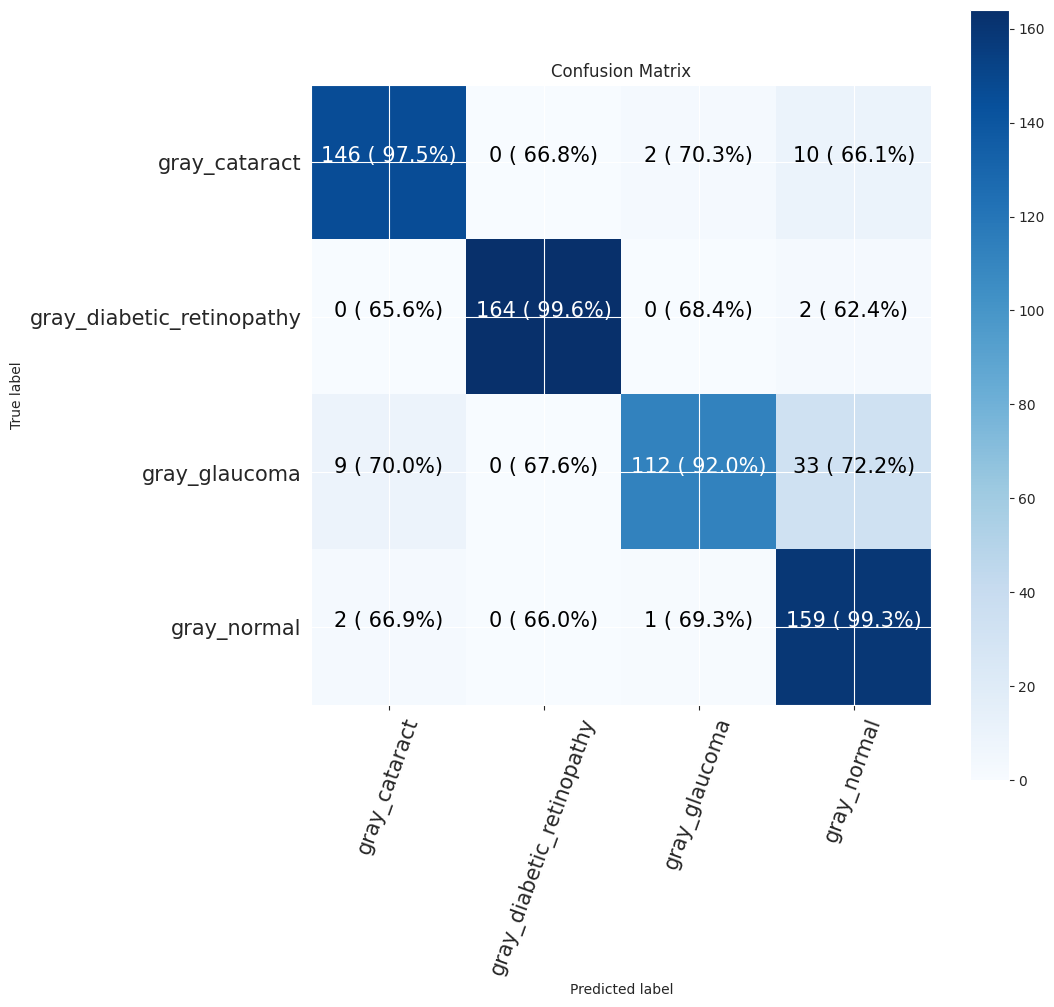

In [315]:
# Save Model
resnet101_model.save("resnet101_model.h5")

model = resnet101_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


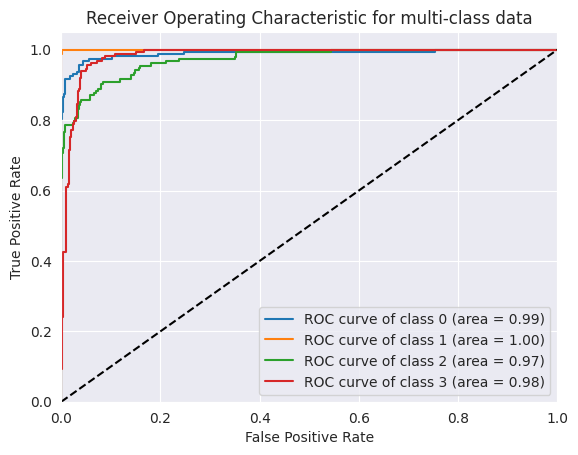

In [316]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **Batch size: 64**

In [317]:
epoch = 20
batchsize = 64

In [318]:
train_dir = "outputgrayscale/train"
test_dir =  "outputgrayscale/test"
val_dir = "outputgrayscale/val"

train_classes = sorted([name for name in os.listdir(train_dir)])
class_names = train_classes  # Assuming class names are the same across train, test, and val

# Load datasets
train_data = image_dataset_from_directory(train_dir, label_mode="categorical",
                                          image_size=(224, 224), batch_size=batchsize,
                                          shuffle=True, seed=42, color_mode='grayscale')

test_data = image_dataset_from_directory(test_dir, label_mode="categorical",
                                         image_size=(224, 224), batch_size=batchsize,
                                         shuffle=False, seed=42, color_mode='grayscale')

val_data = image_dataset_from_directory(val_dir, label_mode="categorical",
                                        image_size=(224, 224), batch_size=batchsize,
                                        shuffle=False, seed=42, color_mode='grayscale')


Found 3813 files belonging to 4 classes.
Found 640 files belonging to 4 classes.
Found 1055 files belonging to 4 classes.


In [319]:
train_data = train_data.map(lambda x, y: (sharpen_image(x), y))
test_data = test_data.map(lambda x, y: (sharpen_image(x), y))
val_data = val_data.map(lambda x, y: (sharpen_image(x), y))

# **EfficientNetV2B3 Model**

In [320]:
efficient_model = tf.keras.applications.EfficientNetV2B3(include_top = False)
efficient_model.trainable = False


In [321]:
inputs = layers.Input(shape=(224, 224, 1), name="input_layer")
x = data_aug(inputs)
# x = inputs
x = efficient_model(x)

# Apply Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.Dense(4)(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)

efficient_model = tf.keras.Model(inputs, outputs)
efficient_model.summary()

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 1)]     0         
                                                                 
 data_augmentation_layer (S  (None, None, None, 1)     0         
 equential)                                                      
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d_2  (None, 1536)              0         
 8 (GlobalAveragePooling2D)                                      
                                                                 
 dense_83 (Dense)            (None, 32)                49184     
                                                          

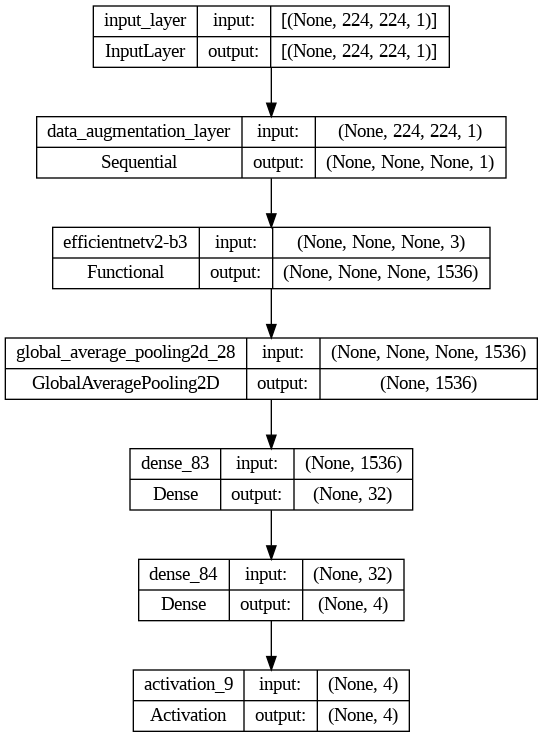

In [322]:
tf.keras.utils.plot_model(efficient_model, show_shapes=True)

In [323]:
efficient_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [324]:
efficient_history = efficient_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
60/60 [==============================] - 53s 681ms/step - loss: 0.8086 - accuracy: 0.6669 - val_loss: 0.8398 - val_accuracy: 0.6227 - lr: 0.0010
Epoch 2/20
60/60 [==============================] - 41s 689ms/step - loss: 0.5979 - accuracy: 0.7637 - val_loss: 0.8079 - val_accuracy: 0.6379 - lr: 0.0010
Epoch 3/20
60/60 [==============================] - 38s 632ms/step - loss: 0.5553 - accuracy: 0.7849 - val_loss: 0.6868 - val_accuracy: 0.7156 - lr: 0.0010
Epoch 4/20
60/60 [==============================] - 39s 644ms/step - loss: 0.5238 - accuracy: 0.7949 - val_loss: 0.6433 - val_accuracy: 0.7280 - lr: 0.0010
Epoch 5/20
60/60 [==============================] - 36s 591ms/step - loss: 0.5046 - accuracy: 0.8033 - val_loss: 0.7353 - val_accuracy: 0.7261 - lr: 0.0010
Epoch 6/20
60/60 [==============================] - 36s 601ms/step - loss: 0.4835 - accuracy: 0.8122 - val_loss: 0.5908 - val_accuracy: 0.7754 - lr: 0.0010
Epoch 7/20
60/60 [==============================] - 37s 617ms/st

EfficientNetV2B3 Evaluation

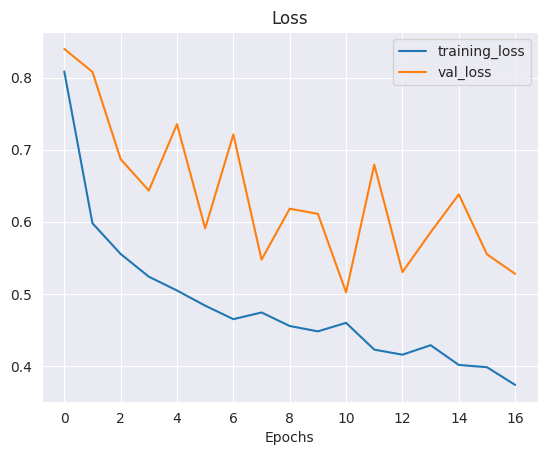

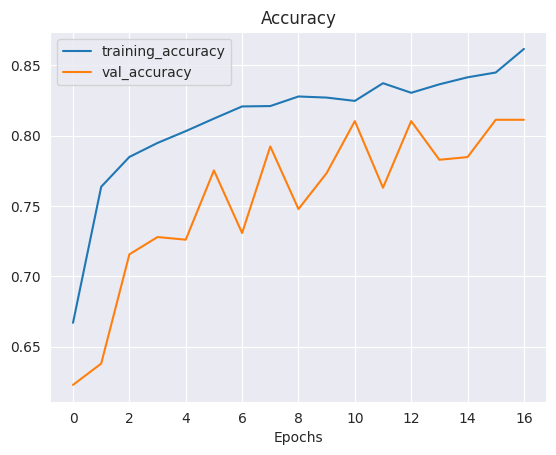

In [325]:
plot_loss_curves(efficient_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 1s 148ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.88       158
           1       0.84      0.93      0.88       166
           2       0.90      0.54      0.67       154
           3       0.69      0.86      0.77       162

    accuracy                           0.81       640
   macro avg       0.82      0.80      0.80       640
weighted avg       0.82      0.81      0.80       640

Specificity: [0.28256513026052105, 0.3168724279835391, 0.1490125673249551, 0.2774451097804391]
Mean Squared Error: : 0.12782955169677734
The average AUC-ROC is 0.9571943885939462


[0.9642857142857143,
 0.6535087719298246,
 0.7262773722627737,
 0.6613636363636364,
 0.6533613445378151,
 0.9736842105263158,
 0.6970802919708029,
 0.6477272727272727,
 0.7142857142857143,
 0.6885964912280702,
 0.8704379562043796,
 0.7431818181818182,
 0.6680672268907563,
 0.6842105263157895,
 0.7062043795620438,
 0.9477272727272728]

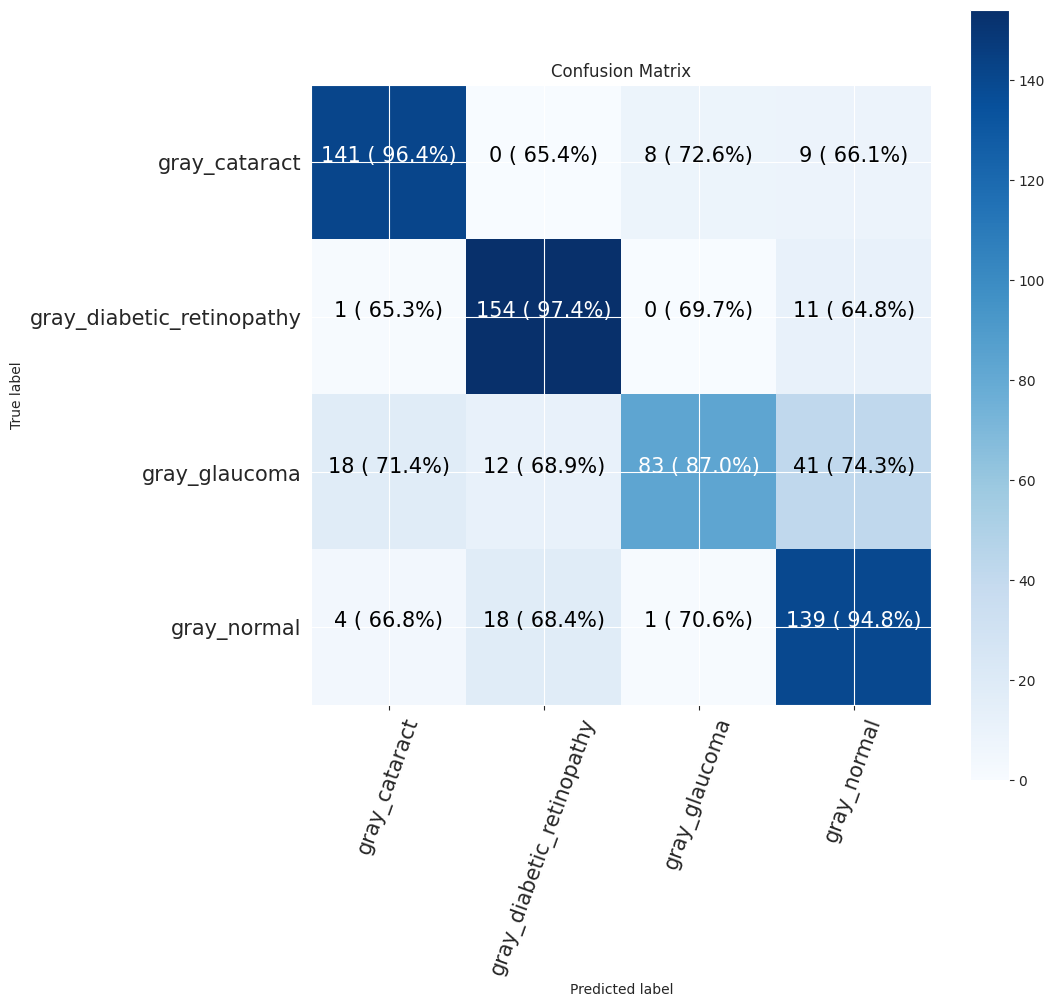

In [326]:
# Save Model
efficient_model.save("efficient_model.h5")

model = efficient_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


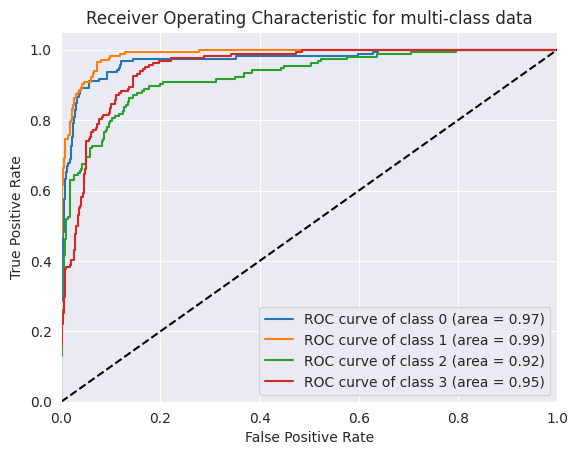

In [327]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **CNN model**

In [328]:
from tensorflow.keras.models import Sequential

# Create a Sequential model
cnn_model = Sequential()

# Add convolutional layers for feature extraction
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))  # Grayscale image has 1 channel

# Freeze the layers in the base model
for layer in cnn_model.layers:
    layer.trainable = False

grayscale_input = layers.Input(shape=(224, 224, 1))

grayscale_input = data_aug(grayscale_input)

cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for dense layers
cnn_model.add(layers.Flatten())

# Add dense layers for classification
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dense(4, activation='softmax'))  # Set num_classes to your specific number of classes

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
cnn_model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_55 (Conv2D)          (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_56 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_57 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_38 (MaxPooli  (None, 26, 26, 128)      

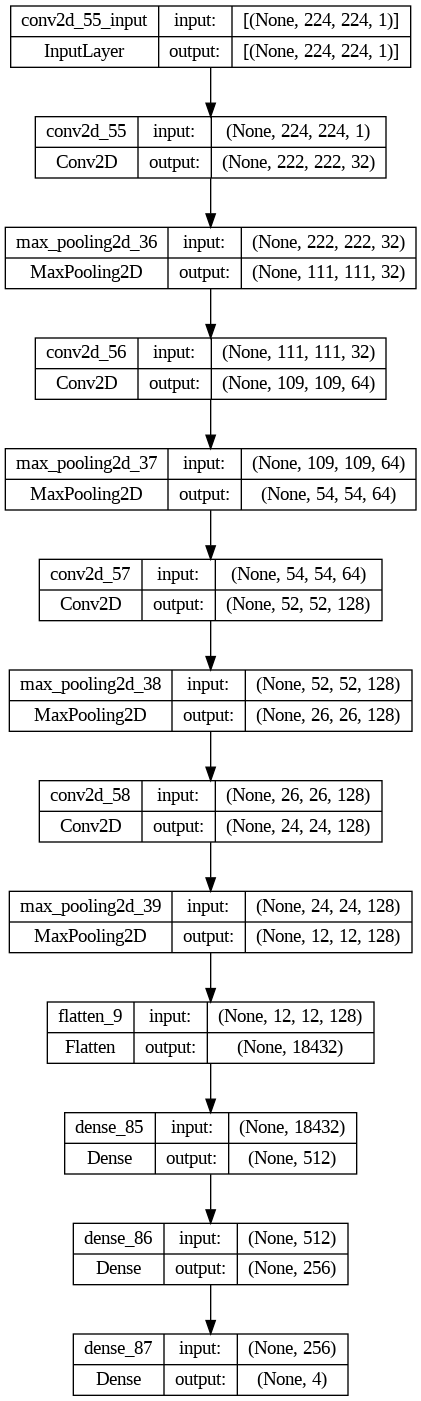

In [329]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [330]:
cnn_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [331]:
cnn_history = cnn_model.fit(train_data,epochs = epoch, validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
60/60 [==============================] - 7s 73ms/step - loss: 6.5880 - accuracy: 0.5130 - val_loss: 0.7506 - val_accuracy: 0.7014 - lr: 0.0010
Epoch 2/20
60/60 [==============================] - 4s 69ms/step - loss: 0.6962 - accuracy: 0.7131 - val_loss: 0.7057 - val_accuracy: 0.7100 - lr: 0.0010
Epoch 3/20
60/60 [==============================] - 4s 69ms/step - loss: 0.6054 - accuracy: 0.7480 - val_loss: 0.5141 - val_accuracy: 0.7943 - lr: 0.0010
Epoch 4/20
60/60 [==============================] - 4s 69ms/step - loss: 0.5033 - accuracy: 0.7918 - val_loss: 0.5341 - val_accuracy: 0.7877 - lr: 0.0010
Epoch 5/20
60/60 [==============================] - 4s 69ms/step - loss: 0.5436 - accuracy: 0.7731 - val_loss: 0.4647 - val_accuracy: 0.8227 - lr: 0.0010
Epoch 6/20
60/60 [==============================] - 4s 69ms/step - loss: 0.4451 - accuracy: 0.8180 - val_loss: 0.4220 - val_accuracy: 0.8351 - lr: 0.0010
Epoch 7/20
60/60 [==============================] - 4s 69ms/step - loss: 0.4

CNN Evaluation

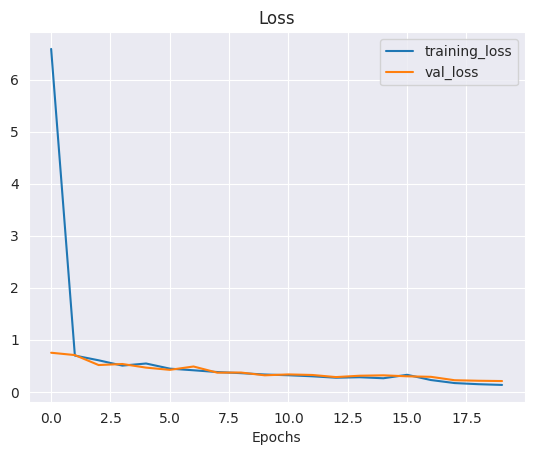

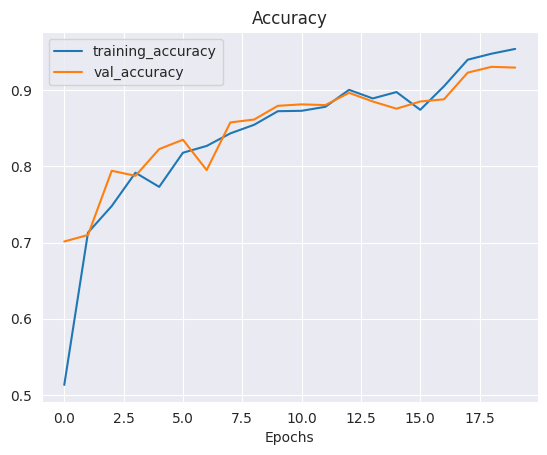

In [332]:
plot_loss_curves(cnn_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 0s 25ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       158
           1       0.99      1.00      0.99       166
           2       0.84      0.77      0.80       154
           3       0.83      0.85      0.84       162

    accuracy                           0.88       640
   macro avg       0.88      0.88      0.88       640
weighted avg       0.88      0.88      0.88       640

Specificity: [0.28, 0.350210970464135, 0.22840690978886757, 0.27236580516898606]
Mean Squared Error: : 0.11333340406417847
The average AUC-ROC is 0.9705323389461089


[0.9621848739495799,
 0.6652542372881356,
 0.6967871485943775,
 0.689873417721519,
 0.6512605042016807,
 1.0,
 0.6666666666666666,
 0.6497890295358649,
 0.7121848739495799,
 0.673728813559322,
 0.929718875502008,
 0.7130801687763713,
 0.6743697478991597,
 0.6610169491525424,
 0.7068273092369478,
 0.9472573839662447]

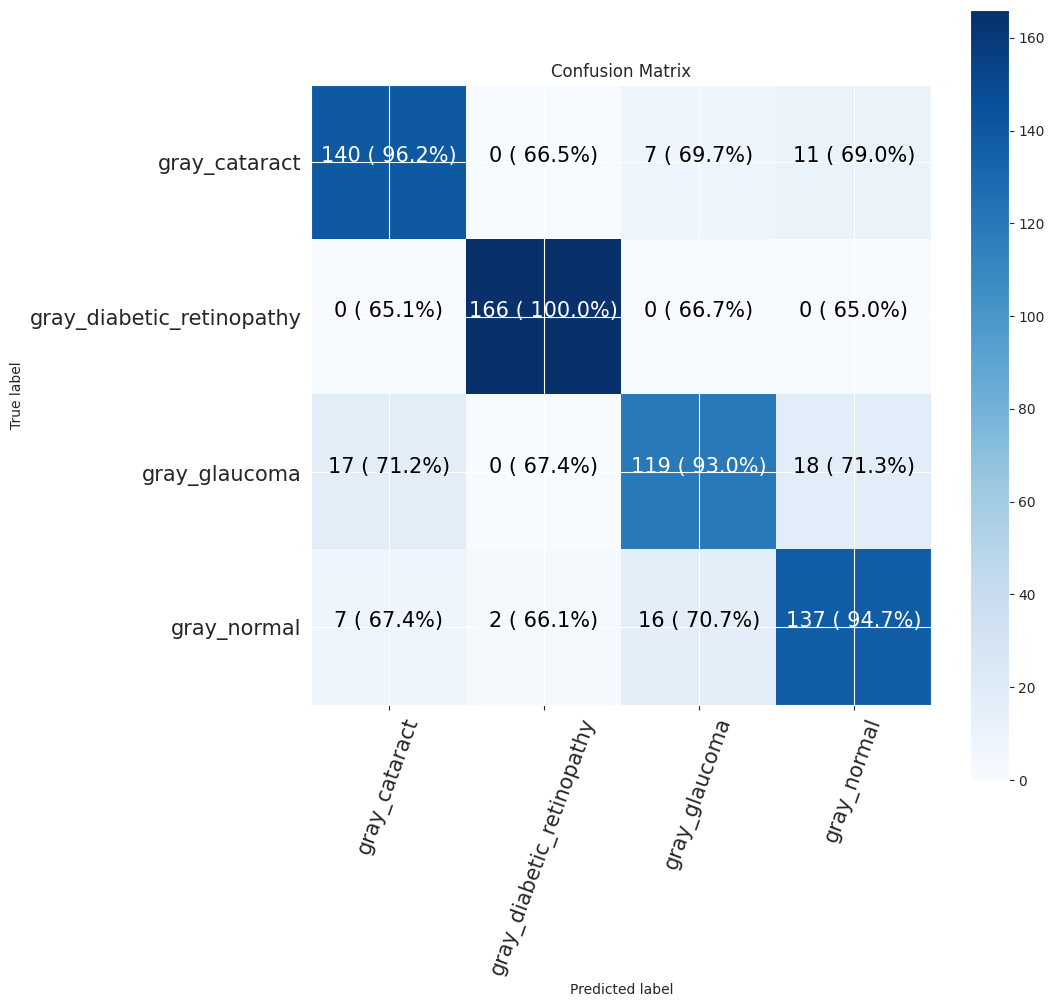

In [333]:
# Save Model
cnn_model.save("cnn_model.h5")

model = cnn_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


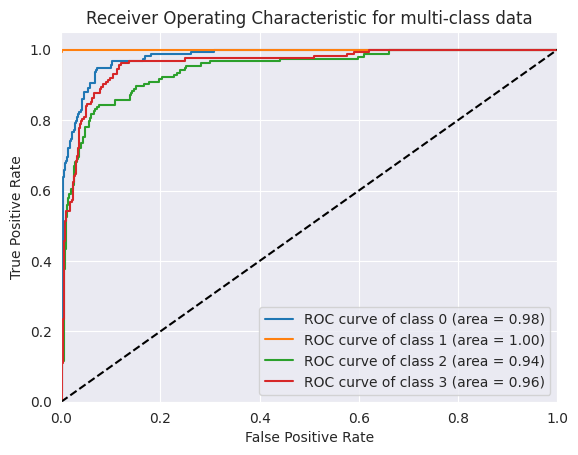

In [334]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet50 Model**



In [335]:
from tensorflow.keras.applications import ResNet50

# Load ResNet-50 without the top classification layers (include_top=False)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet50_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)
# Convert grayscale to 3 channels (matching the input requirement of ResNet-50)
conv_layer = Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-50 model
x = resnet50_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-50 model for grayscale images
resnet50_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet50_model.summary()


Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_80 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_59 (Conv2D)          (None, None, None, 3)     30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
 9 (GlobalAveragePooling2D)                                      
                                                                 
 dense_88 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_89 (Dense)            (None, 4)                 4100      
                                                          

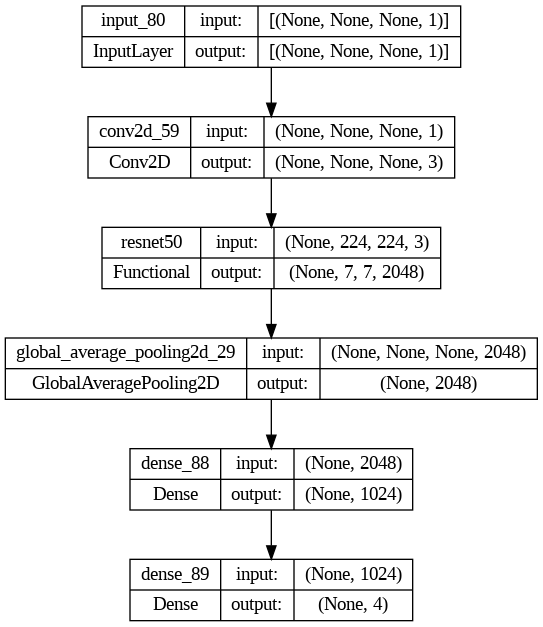

In [336]:
tf.keras.utils.plot_model(resnet50_model, show_shapes=True)

In [337]:
resnet50_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [338]:
resnet50_history = resnet50_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
60/60 [==============================] - 37s 549ms/step - loss: 0.8643 - accuracy: 0.7147 - val_loss: 0.4604 - val_accuracy: 0.8265 - lr: 0.0010
Epoch 2/20
60/60 [==============================] - 32s 529ms/step - loss: 0.3942 - accuracy: 0.8497 - val_loss: 0.3495 - val_accuracy: 0.8692 - lr: 0.0010
Epoch 3/20
60/60 [==============================] - 32s 527ms/step - loss: 0.3107 - accuracy: 0.8801 - val_loss: 0.2807 - val_accuracy: 0.8967 - lr: 0.0010
Epoch 4/20
60/60 [==============================] - 32s 530ms/step - loss: 0.2545 - accuracy: 0.9056 - val_loss: 0.2637 - val_accuracy: 0.8910 - lr: 0.0010
Epoch 5/20
60/60 [==============================] - 32s 529ms/step - loss: 0.2362 - accuracy: 0.9079 - val_loss: 0.2065 - val_accuracy: 0.9232 - lr: 0.0010
Epoch 6/20
60/60 [==============================] - 32s 528ms/step - loss: 0.2157 - accuracy: 0.9166 - val_loss: 0.1943 - val_accuracy: 0.9223 - lr: 0.0010
Epoch 7/20
60/60 [==============================] - 32s 527ms/st

ResNet50 Evaluation

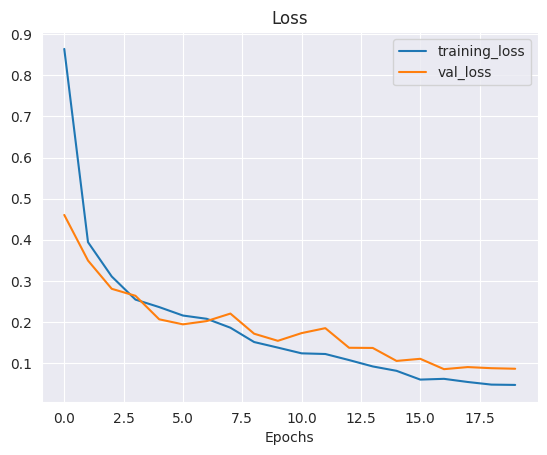

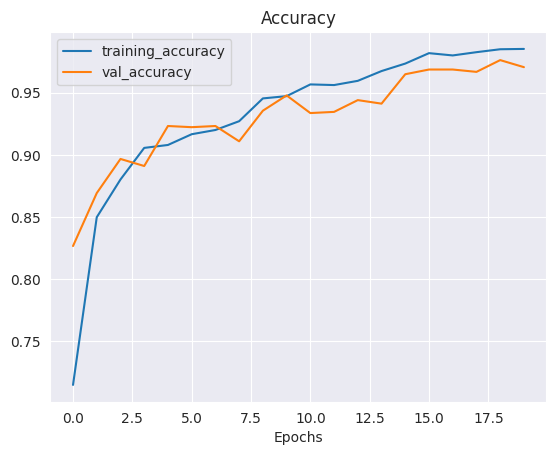

In [339]:
plot_loss_curves(resnet50_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 2s 175ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       158
           1       0.99      0.99      0.99       166
           2       0.87      0.90      0.89       154
           3       0.95      0.90      0.92       162

    accuracy                           0.94       640
   macro avg       0.94      0.94      0.94       640
weighted avg       0.94      0.94      0.94       640

Specificity: [0.30612244897959184, 0.3473684210526316, 0.2774451097804391, 0.29292929292929293]
Mean Squared Error: : 0.10251618921756744
The average AUC-ROC is 0.9929718206111965


[0.9832635983263598,
 0.6659619450317125,
 0.6860706860706861,
 0.6782786885245902,
 0.6527196652719666,
 0.9978858350951374,
 0.656964656964657,
 0.6598360655737705,
 0.6924686192468619,
 0.678646934460888,
 0.9688149688149689,
 0.6967213114754098,
 0.6715481171548117,
 0.6575052854122622,
 0.6881496881496881,
 0.9651639344262295]

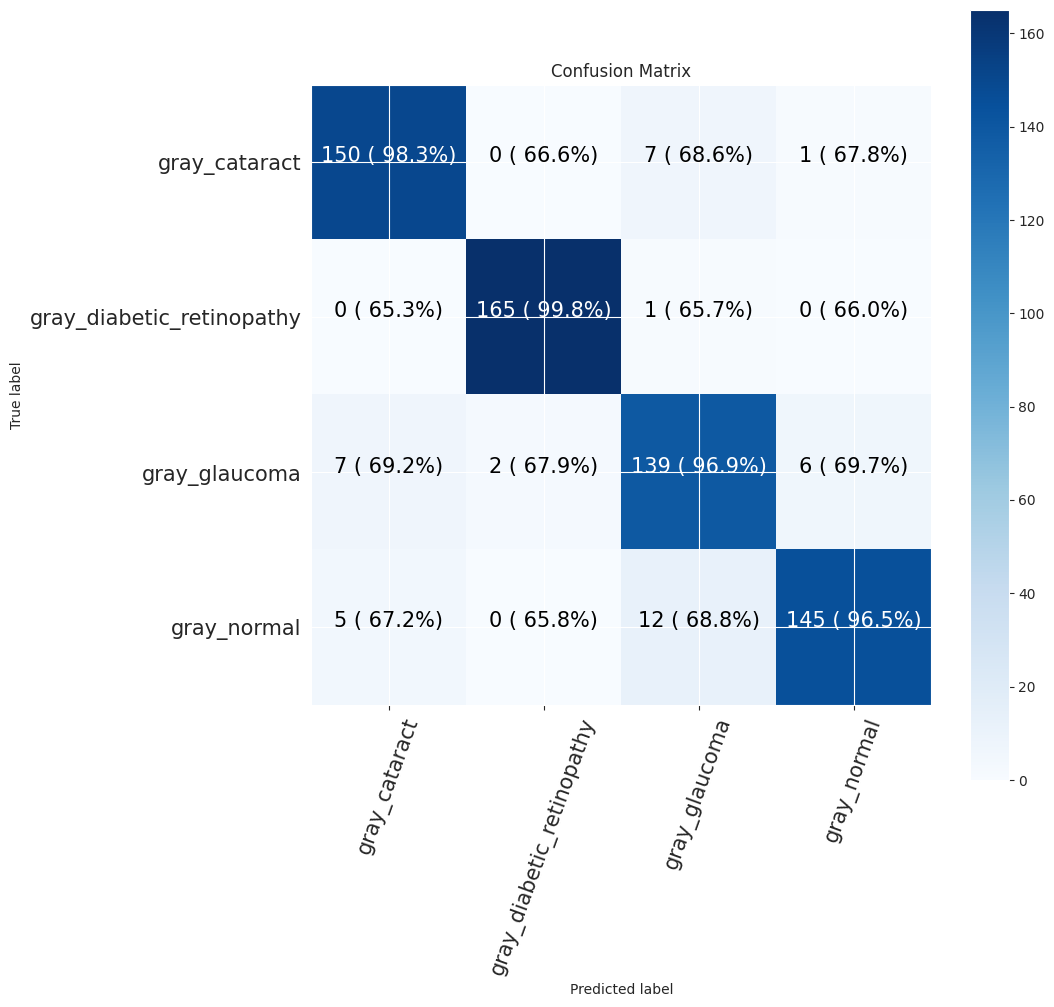

In [340]:
# Save Model
resnet50_model.save("resnet50_model.h5")

model = resnet50_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


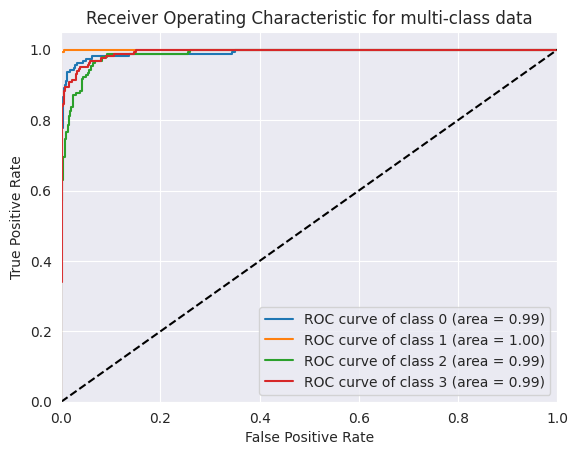

In [341]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet101**

In [342]:
from tensorflow.keras.applications import ResNet101

# Load ResNet-101 without the top classification layers (include_top=False)
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet101_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)

# Convert grayscale to 3 channels (matching the input requirement of ResNet-101)
conv_layer = layers.Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-101 model
x = resnet101_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-101 model for grayscale images
resnet101_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet101_model.summary()


Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_83 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_60 (Conv2D)          (None, None, None, 3)     30        
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
 0 (GlobalAveragePooling2D)                                      
                                                                 
 dense_90 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_91 (Dense)            (None, 4)                 4100      
                                                          

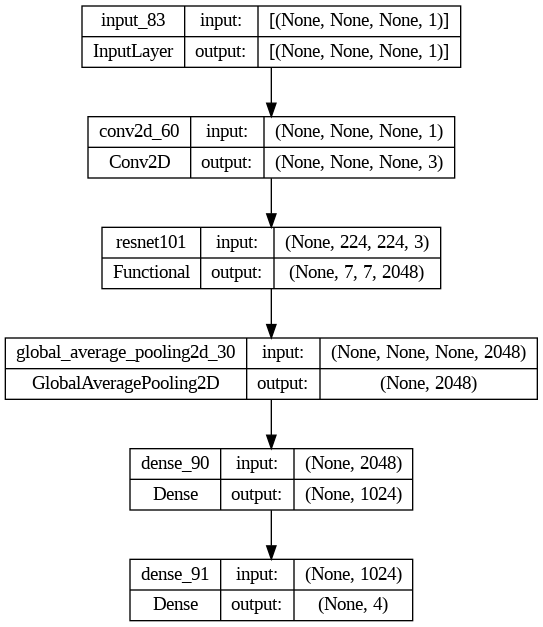

In [343]:
tf.keras.utils.plot_model(resnet101_model, show_shapes=True)

In [344]:
resnet101_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [345]:
resnet101_history= resnet101_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
60/60 [==============================] - 62s 907ms/step - loss: 1.0260 - accuracy: 0.6758 - val_loss: 0.4782 - val_accuracy: 0.8076 - lr: 0.0010
Epoch 2/20
60/60 [==============================] - 52s 860ms/step - loss: 0.4521 - accuracy: 0.8238 - val_loss: 0.4073 - val_accuracy: 0.8455 - lr: 0.0010
Epoch 3/20
60/60 [==============================] - 52s 862ms/step - loss: 0.3767 - accuracy: 0.8547 - val_loss: 0.3224 - val_accuracy: 0.8739 - lr: 0.0010
Epoch 4/20
60/60 [==============================] - 52s 862ms/step - loss: 0.3585 - accuracy: 0.8605 - val_loss: 0.3499 - val_accuracy: 0.8635 - lr: 0.0010
Epoch 5/20
60/60 [==============================] - 52s 864ms/step - loss: 0.2960 - accuracy: 0.8833 - val_loss: 0.3073 - val_accuracy: 0.8768 - lr: 0.0010
Epoch 6/20
60/60 [==============================] - 52s 863ms/step - loss: 0.2941 - accuracy: 0.8854 - val_loss: 0.3072 - val_accuracy: 0.8853 - lr: 0.0010
Epoch 7/20
60/60 [==============================] - 52s 861ms/st

ResNet101 Evaluation

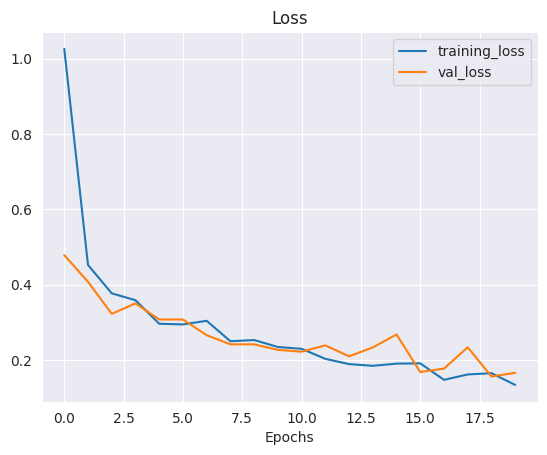

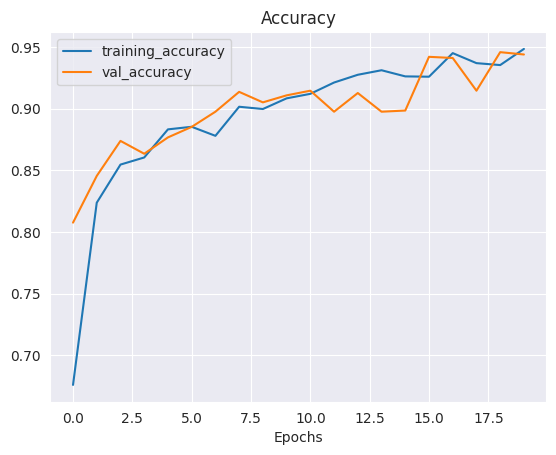

In [346]:
plot_loss_curves(resnet101_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 3s 297ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       158
           1       0.98      0.99      0.99       166
           2       0.93      0.77      0.84       154
           3       0.83      0.92      0.87       162

    accuracy                           0.90       640
   macro avg       0.91      0.90      0.90       640
weighted avg       0.91      0.90      0.90       640

Specificity: [0.29292929292929293, 0.3473684210526316, 0.22840690978886757, 0.3034623217922607]
Mean Squared Error: : 0.10966044664382935
The average AUC-ROC is 0.9825275959372932


[0.9726890756302521,
 0.6652542372881356,
 0.69921875,
 0.6760869565217391,
 0.6512605042016807,
 0.9978813559322034,
 0.67578125,
 0.6413043478260869,
 0.7037815126050421,
 0.6758474576271186,
 0.931640625,
 0.7108695652173913,
 0.6722689075630253,
 0.6610169491525424,
 0.693359375,
 0.9717391304347827]

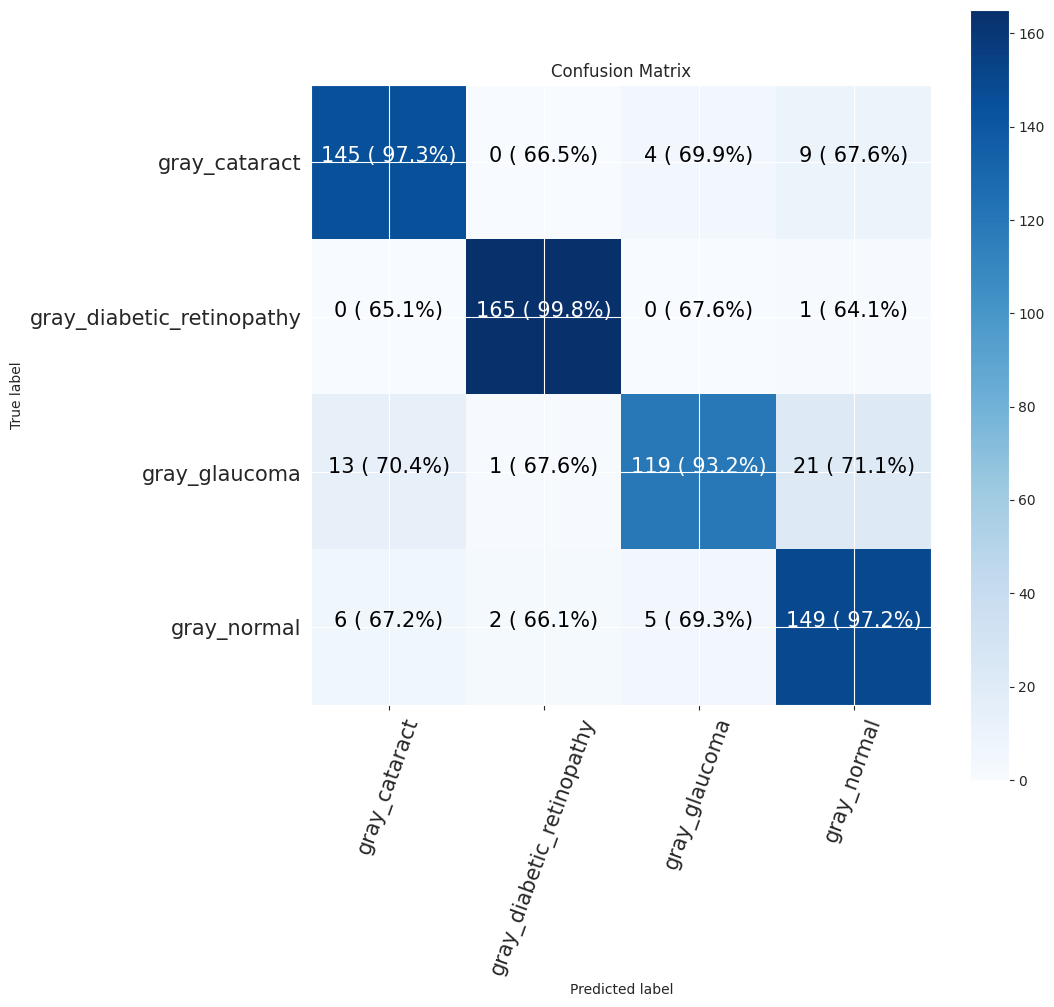

In [347]:
# Save Model
resnet101_model.save("resnet101_model.h5")

model = resnet101_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


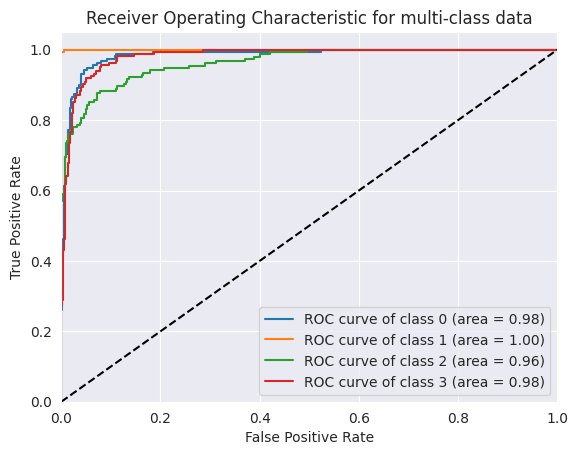

In [348]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()